## Retrieve data from DB
PTEN:
- DMS scores: https://www.mavedb.org/score-sets/urn:mavedb:00000013-a-1
- Pairwise Alignment: https://www.ensembl.org/Homo_sapiens/Gene/Compara_Ortholog/Alignment?db=core;g=ENSG00000171862;g1=ENSDARG00000056623;hom_id=202046236;r=10:87862638-87971930

PAX6 Homeobox domain:
- https://www.mavedb.org/score-sets/urn:mavedb:00000949-a-1
- Multiple Alignment: https://www.ensembl.org/Homo_sapiens/Gene/Compara_Ortholog?db=core;g=ENSG00000007372;r=11:31784779-31817961

CYP2C19:
- https://www.mavedb.org/score-sets/urn:mavedb:00001199-a-1
- Multiple Alignment: https://www.ensembl.org/Homo_sapiens/Gene/Compara_Ortholog?db=core;g=ENSG00000165841;r=10:94762681-94855547

### Deep Mutational Scanning (DMS) Scores

#### *PTEN* and *PAX6 Homeobox Domain* DMS Score
- **0** - Wild-Type (WT)
- **Score > 0** - Improved Function
- **Score < 0** - Deleterious

#### *CYP2C19* DMS Score
- **0** - Nonsense Variant
- **0 < Score < 1** - Reduced Function
- **Score = 1** - Wild-Type (WT)
- **Score > 1** - Improved Function

### Shannon Entropy
- **Entropy = 0** - Highly Conserved
- **Entropy > 0** - The higher the value, the more tolerant to changes

### Substitution scores (eg. BLOSUM62, PAM250, etc.)
- Score < 0: Unfavorable substitution
- Score > 0: Favorable substitution
- Score = 0: Neutral substitution

### After minmax scaling of scores:
#### *CYP2C19* DMS scaled
- Values near 0: Indicate reduced function relative to the observed range of scores.
- Values near 1: Indicate improved function relative to the observed range of scores.
- Values around 0.5: Represent scores that are intermediate in terms of functionality compared to the extremes.

#### Substitution scores (e.g. BLOSUM62 minmax scaled)
- Values near 0: Indicate unfavorable substitutions relative to the observed range.
- Values near 1: Indicate favorable substitutions relative to the observed range.
- Values around 0.5: Represent neutral to moderately favorable/unfavorable substitutions, depending on the distribution of original scores.


In [34]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from scipy.stats import pearsonr, spearmanr, linregress

In [2]:
# Connect to the database
conn = sqlite3.connect('compar_gen_data.db')
cursor = conn.cursor()

In [26]:
# all functions

# Print table content
def print_table(table_name, gene_name=None):
    table = PrettyTable()
    query = ""
    field_names = []

    if table_name == "Species":
        query = "SELECT * FROM Species"
        field_names = ["Species ID", "Species Name"]
        
    elif table_name == "Gene":
        query = "SELECT gene_id, gene_name FROM Gene ORDER BY Gene.gene_id"
        field_names = ["Gene ID", "Gene Name"]

    elif table_name == "Mutation":
        query = f'''
            SELECT Mutation.mutation_id, Gene.gene_name, Species.species_name, Mutation.position, 
                   Mutation.ancestral_residue, Mutation.variant_residue, Mutation.edit_distance
            FROM Mutation
            JOIN Gene ON Mutation.gene_id = Gene.gene_id
            JOIN Species ON Mutation.species_id = Species.species_id
            WHERE Gene.gene_name = '{gene_name}'
                AND (Mutation.edit_distance = 1)
        '''
        field_names = ["Mutation ID", "Gene", "Species", "Position", "Ancestral", "Variant", "Edit Distance"]

    elif table_name == "DMS":
        query = f'''
            SELECT DMS.dms_id, Gene.gene_name, Mutation.position, Mutation.ancestral_residue, 
                   Mutation.variant_residue, DMS.score, DMS.score_minmax_scaled
            FROM DMS
            JOIN Mutation ON DMS.mutation_id = Mutation.mutation_id
            JOIN Gene ON Mutation.gene_id = Gene.gene_id
            WHERE Gene.gene_name = '{gene_name}'
            ORDER BY Mutation.position
        '''
        field_names = ["DMS ID", "Gene", "Position", "Ancestral", "Variant", "Score", "MinMaxScaled"]

    elif table_name == "MSA":
        query = f'''
            SELECT MSA.msa_id, Gene.gene_name, Species.species_name, Mutation.position, Mutation.ancestral_residue, 
                   Mutation.variant_residue, ROUND(MSA.shannon_entropy, 3), ROUND(MSA.percentage_identity, 3), 
                   ROUND(MSA.variant_percentage_residue, 3)
            FROM MSA
            JOIN Mutation ON MSA.mutation_id = Mutation.mutation_id
            JOIN Species ON Mutation.species_id = Species.species_id
            JOIN Gene ON Mutation.gene_id = Gene.gene_id
            WHERE Gene.gene_name = '{gene_name}'
            ORDER BY Mutation.position
        '''
        field_names = ["MSA ID", "Gene", "Species", "Position", "Ancestral", "Variant", "shannon", "% identity", "Variant AA %"]

    elif table_name == "IntegratedData":
        query = f'''
            SELECT IntegratedData.integrated_data_id, Gene.gene_name, Mutation.position,
                   Mutation.ancestral_residue, Mutation.variant_residue, ROUND(IntegratedData.shannon_entropy, 3),
                   ROUND(IntegratedData.percentage_identity, 3), ROUND(IntegratedData.dms_score, 3), 
                   ROUND(IntegratedData.variant_percentage_residue, 3), IntegratedData.BLOSUM62, IntegratedData.PAM250
            FROM IntegratedData
            JOIN Mutation ON IntegratedData.mutation_id = Mutation.mutation_id
            JOIN Gene ON Mutation.gene_id = Gene.gene_id
            WHERE Gene.gene_name = '{gene_name}'
            GROUP BY Mutation.position, Mutation.ancestral_residue, Mutation.variant_residue
            ORDER BY Mutation.position
        '''
        field_names = ["ID", "Gene", "Pos", "Anc", "Var", 
                       "Shannon", "% Identity", "DMS", "VariantAA%"]

    elif table_name == "SubstitutionMatrices":
        query = "SELECT amino_acid_x, amino_acid_y, BLOSUM62, PAM250, BLOSUM62_minmax_scaled, PAM250_minmax_scaled FROM SubstitutionMatrices"
        field_names = ["AA_x", "AA_y", "BLOSUM62", "PAM250", "BLOSUM62_minmax_sc", "PAM250_minmax_sc"]
        #query = "SELECT * FROM SubstitutionMatrices"
        #field_names = ["AA_x", "AA_y", "BENNER22", "BENNER6", "BENNER74", 
        #               "BLASTN", "BLASTP", "BLOSUM45", "BLOSUM50", "BLOSUM62", "BLOSUM80", "BLOSUM90", "DAYHOFF", 
        #               "FENG", "GENETIC", "GONNET1992", "JOHNSON", "JONES", "LEVIN", "MCLACHLAN", "MDM78", "MEGABLAST", 
        #               "NUC_4_4", "PAM250", "PAM30", "PAM70", "RAO", "RISLER", "STR"]
        
    else:
        print(f"Table '{table_name}' is not recognized.")
        return

    cursor.execute(query)
    data = cursor.fetchall()

    table.field_names = field_names
    for row in data:
        table.add_row(row)
    
    print(f"{table_name}:")
    print(table)
    print('')

# Clean table content
def clean_table(table):
    cursor.execute(f'''
        DELETE FROM {table}
    ''')
    conn.commit()
    print(f"{table} table cleaned successfully.")

def remove_records(table, field_name, field_value):
    sql_query = f"DELETE FROM {table} WHERE {field_name} = ?"
    cursor.execute(sql_query, (field_value,))
    conn.commit()

#does not work, need to fix:
def remove_records_by_foreign_key(table, foreign_key_field, referenced_table, referenced_field, referenced_value):
    sql_query = f"SELECT {referenced_field} FROM {referenced_table} WHERE {referenced_field} = ?"
    cursor.execute(sql_query, (referenced_value,))
    referenced_ids = cursor.fetchall()
    referenced_ids = tuple(id_[0] for id_ in referenced_ids)
    sql_query = f"DELETE FROM {table} WHERE {foreign_key_field} IN ({','.join('?' * len(referenced_ids))})"
    cursor.execute(sql_query, referenced_ids)
    conn.commit()

In [30]:
# PRINT table
#print_table("Species")
#print_table("Gene", "CYP2C19")
#print_table("Mutation", "CYP2C19")

#print_table("IntegratedData", "CYP2C19")
#print_table("SubstitutionMatrices")

#print_table("MSA", "CYP2C19")
#print_table("DMS", "CYP2C19")

cursor.execute("PRAGMA table_info(IntegratedData);")
table_info = cursor.fetchall()
# Print the table structure
for column in table_info:
    print(column)

(0, 'integrated_data_id', 'INTEGER', 0, None, 1)
(1, 'mutation_id', 'INTEGER', 0, None, 0)
(2, 'dms_score', 'REAL', 0, None, 0)
(3, 'shannon_entropy', 'REAL', 0, None, 0)
(4, 'jsd', 'REAL', 0, None, 0)
(5, 'phylop', 'REAL', 0, None, 0)
(6, 'phastcons', 'REAL', 0, None, 0)
(7, 'gerp', 'REAL', 0, None, 0)
(8, 'percentage_identity', 'REAL', 0, None, 0)
(9, 'ci', 'REAL', 0, None, 0)
(10, 'variant_percentage_residue', 'REAL', 0, None, 0)
(11, 'BENNER22', 'REAL', 0, None, 0)
(12, 'BENNER6', 'REAL', 0, None, 0)
(13, 'BENNER74', 'REAL', 0, None, 0)
(14, 'BLASTN', 'REAL', 0, None, 0)
(15, 'BLASTP', 'REAL', 0, None, 0)
(16, 'BLOSUM45', 'REAL', 0, None, 0)
(17, 'BLOSUM50', 'REAL', 0, None, 0)
(18, 'BLOSUM62', 'REAL', 0, None, 0)
(19, 'BLOSUM80', 'REAL', 0, None, 0)
(20, 'BLOSUM90', 'REAL', 0, None, 0)
(21, 'DAYHOFF', 'REAL', 0, None, 0)
(22, 'FENG', 'REAL', 0, None, 0)
(23, 'GENETIC', 'REAL', 0, None, 0)
(24, 'GONNET1992', 'REAL', 0, None, 0)
(25, 'JOHNSON', 'REAL', 0, None, 0)
(26, 'JONES', 'REA

# Visualizations

In [39]:
# Helping functions for visualisation functions

# Helping function to fetch data for variant residue percentage vs dms plot from the database (used in plot_var_residue_percent_vs_dms)
def fetch_var_residue(gene_name, position=None):
    query = '''
        SELECT Mutation.position, Mutation.variant_residue, IntegratedData.variant_percentage_residue, IntegratedData.dms_score, Mutation.ancestral_residue
        FROM IntegratedData
        JOIN Mutation ON IntegratedData.mutation_id = Mutation.mutation_id
        JOIN Gene ON Mutation.gene_id = Gene.gene_id
        WHERE Gene.gene_name = ?
    '''
    params = [gene_name]
    
    if position is not None:
        query += ' AND Mutation.position = ?'
        params.append(position)
    
    cursor.execute(query, params)
    data = cursor.fetchall()
    
    return data

# Helping function (used for violin_plot_dms_scores function)
def fetch_pairplot_residue(gene_name):
    query = '''
        SELECT Mutation.position, Mutation.ancestral_residue, Mutation.variant_residue, IntegratedData.variant_percentage_residue, IntegratedData.dms_score
        FROM IntegratedData
        JOIN Mutation ON IntegratedData.mutation_id = Mutation.mutation_id
        JOIN Gene ON Mutation.gene_id = Gene.gene_id
        WHERE Gene.gene_name = ?
    '''
    cursor.execute(query, (gene_name,))
    data = cursor.fetchall()
    
    return data
    
# Helping function to create violin plot with dots for DMS scores (used for plot_pair_distribution function)
def violin_plot_dms_scores(left_data, right_data, title):
    left_dms_scores = [row[4] for row in left_data]
    right_dms_scores = [row[4] for row in right_data]
    
    # Create a combined dataframe for plotting
    plot_data = {
        'DMS Score': left_dms_scores + right_dms_scores,
        'Category': ['AA1 to AA2'] * len(left_dms_scores) + ['AA2 to AA1'] * len(right_dms_scores)
    }
    
    plt.figure(figsize=(10, 6))
    
    sns.violinplot(x='Category', y='DMS Score', hue='Category', data=plot_data, inner=None, legend=False, palette='muted')
    
    # Overlay the dots
    sns.swarmplot(x='Category', y='DMS Score', data=plot_data, color='k', alpha=0.6)
    
    plt.title(title)
    plt.grid(True)
    plt.show()

# Helping function (used in violin_plot_dms_scores_for_grid)
def fetch_gridplot_residue(gene_name, scaled=False):
    if scaled:
        query = '''
            SELECT Mutation.position, Mutation.ancestral_residue, Mutation.variant_residue, IntegratedData.variant_percentage_residue, IntegratedData.dms_minmax_scaled, IntegratedData.BLOSUM62_minmax_scaled, IntegratedData.PAM250_minmax_scaled
            FROM IntegratedData
            JOIN Mutation ON IntegratedData.mutation_id = Mutation.mutation_id
            JOIN Gene ON Mutation.gene_id = Gene.gene_id
            WHERE Gene.gene_name = ?
        '''
    else:
        query = '''
            SELECT Mutation.position, Mutation.ancestral_residue, Mutation.variant_residue, IntegratedData.variant_percentage_residue, IntegratedData.dms_score, IntegratedData.BLOSUM62, IntegratedData.PAM250
            FROM IntegratedData
            JOIN Mutation ON IntegratedData.mutation_id = Mutation.mutation_id
            JOIN Gene ON Mutation.gene_id = Gene.gene_id
            WHERE Gene.gene_name = ?
        '''
    cursor.execute(query, (gene_name,))
    data = cursor.fetchall()
    
    return data

# Helping function (used in plot_pair_distribution_grid)
def violin_plot_dms_scores_for_grid(ax, left_data, right_data, ylim, show_y_label, ancestral, variant):
    left_dms_scores = [row[4] for row in left_data]
    right_dms_scores = [row[4] for row in right_data]
    
    # Create a combined dataframe for plotting
    plot_data = pd.DataFrame({
        'DMS Score': left_dms_scores + right_dms_scores,
        'Category': [f'{ancestral} to {variant}'] * len(left_dms_scores) + [f'{variant} to {ancestral}'] * len(right_dms_scores)
    })
    
    sns.violinplot(x='Category', y='DMS Score', hue='Category', data=plot_data, inner=None, legend=False, palette='muted', ax=ax, alpha=0.1)
    
    # Overlay the dots
    sns.swarmplot(x='Category', y='DMS Score', data=plot_data, color='k', alpha=0.6, ax=ax)
    
    ax.set_ylim(ylim)
    ax.grid(True)
    
    if not show_y_label:
        ax.set_ylabel('')
    ax.set_xlabel('')

In [73]:
# Visualisation functions

# Bar plot showing dms score vs dot plot for corresponding shannon entropy
def plot_dms_and_entropy(gene_name):
    # Fetch data from MSA table
    msa_query = f'''
        SELECT Mutation.position, MSA.shannon_entropy
        FROM MSA
        JOIN Mutation ON MSA.mutation_id = Mutation.mutation_id
        WHERE Mutation.gene_id = (SELECT gene_id FROM Gene WHERE gene_name = '{gene_name}')
            
    '''
    msa_df = pd.read_sql_query(msa_query, conn)

    # Fetch data from DMS table
    dms_query = f'''
        SELECT Mutation.position, DMS.score
        FROM DMS
        JOIN Mutation ON DMS.mutation_id = Mutation.mutation_id
        WHERE Mutation.gene_id = (SELECT gene_id FROM Gene WHERE gene_name = '{gene_name}')
            
    '''
    dms_df = pd.read_sql_query(dms_query, conn)

    # Calculate mean DMS score for each position
    mean_dms_scores = dms_df.groupby('position')['score'].mean().reset_index()

    # Merge MSA and mean DMS score data on position
    merged_df = pd.merge(msa_df, mean_dms_scores, on='position', how='inner')

    # Sort the dataframe by position
    merged_df.sort_values('position', inplace=True)

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar plot for mean DMS scores
    color = 'tab:orange'
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Mean DMS score', color=color)
    bars = ax1.bar(merged_df['position'], merged_df['score'], color=color, alpha=0.6, label='Mean DMS score')
    ax1.tick_params(axis='y', labelcolor=color)

    # Scatter plot for Shannon entropy
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Shannon entropy', color=color)
    scatter = ax2.scatter(merged_df['position'], merged_df['shannon_entropy'], color=color, label='Shannon entropy',
                          s=5, zorder=10)  # Adjust marker size
    ax2.tick_params(axis='y', labelcolor=color)

    # Title and labels
    plt.title(f'Mean DMS score and Shannon entropy across positions {gene_name}')
    fig.tight_layout()

    # Show plot
    plt.show()


# Plot correlations between chosen conservation score and dms score
def visualize_correlations(gene_name, table_name, field_1, field_2, plot_type='scatter', unique_aa_pairs=False, mean_across_aa_pairs=False):
    # Query to fetch data from the specified table for the given gene_name
    query = f'''
        SELECT {table_name}.{field_1}, {table_name}.{field_2}, 
               Mutation.ancestral_residue, Mutation.variant_residue
        FROM {table_name}
        JOIN Mutation ON {table_name}.mutation_id = Mutation.mutation_id
        JOIN Gene ON Mutation.gene_id = Gene.gene_id
        WHERE Gene.gene_name = '{gene_name}'
        AND {table_name}.{field_1} IS NOT NULL
        AND {table_name}.{field_2} IS NOT NULL
        AND (Mutation.edit_distance = 1)
    '''
    df = pd.read_sql_query(query, conn)
    
    # If unique_aa_pairs is True, filter for unique amino acid pairs
    if unique_aa_pairs:
        df = df.drop_duplicates(subset=['ancestral_residue', 'variant_residue'])
    
    # If mean_across_aa_pairs is True, calculate the mean values for each unique pair of residues
    if mean_across_aa_pairs:
        df = df.groupby(['ancestral_residue', 'variant_residue']).agg({field_1: 'mean', field_2: 'mean'}).reset_index()
    
    
    # Calculate Pearson and Spearman correlations
    pearson_corr, pearson_p = pearsonr(df[field_1], df[field_2])
    spearman_corr, spearman_p = spearmanr(df[field_1], df[field_2])
    
    # Calculate linear regression
    slope, intercept, r_value, p_value, std_err = linregress(df[field_1], df[field_2])
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    if plot_type == 'scatter':
        ax.scatter(df[field_1], df[field_2], alpha=0.6)
        ax.set_title(f'Scatter plot of {field_1} vs {field_2} for {gene_name}')
        # Add linear regression line
        ax.plot(df[field_1], intercept + slope * df[field_1], color='red', label='Regression')

    elif plot_type == 'hexbin':
        hb = ax.hexbin(df[field_1], df[field_2], gridsize=50, cmap='Blues', mincnt=1)
        ax.set_title(f'Hexbin plot of {field_1} vs {field_2} for {gene_name}')
        cb = fig.colorbar(hb, ax=ax, label='Count')
        # Add linear regression line (for hexbin, need to use scatter plot for line)
        ax.plot(df[field_1], intercept + slope * df[field_1], color='red', label='Regression')
    else:
        plt.close(fig)
        raise ValueError("Invalid plot_type. Supported types are 'scatter' and 'hexbin'.")
    
    ax.set_xlabel(field_1)
    ax.set_ylabel(field_2)
    
    # Add Pearson and Spearman correlation values to the plot
    plt.figtext(0.15, 0.85, f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
    plt.figtext(0.15, 0.80, f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

    # Show legend
    ax.legend()
    
    plt.show()


# Plot variant residue percentage (proportion of variant amino acid in the position) vs dms score - individual plots
def plot_var_residue_percent_vs_dms_individual(gene_name, position=None):
    data = fetch_var_residue(gene_name, position)
    
    if not data:
        print(f"No data found for gene_name: {gene_name} and position: {position}")
        return
    
    # Sort data by position
    data_sorted = sorted(data, key=lambda x: x[0])
    positions = sorted(set(row[0] for row in data_sorted))
    
    for pos in positions:
        pos_data = [row for row in data if row[0] == pos]
        x_values = [row[2] for row in pos_data]
        y_values = [row[3] for row in pos_data]
        labels = [row[1] for row in pos_data]
        ancestral = [row[4] for row in pos_data]

        plt.figure(figsize=(10, 6))
        plt.scatter(x_values, y_values)
        
        for i, label in enumerate(labels):
            plt.annotate(label, (x_values[i], y_values[i]))

        plt.xlabel('Variant residue percentage')
        plt.ylabel('DMS Score')
        plt.title(f'Gene: {gene_name}, Position: {pos}, Ancestral: {ancestral[0]}')
        plt.grid(True)
        plt.show()


# Plot variant residue percentage (proportion of variant amino acid in the position) vs dms score - grid of plots
def plot_var_residue_percent_vs_dms_grid(gene_name, position=None):
    data = fetch_var_residue(gene_name, position)
    
    if not data:
        print(f"No data found for gene_name: {gene_name} and position: {position}")
        return
    
    # Sort data by position
    data_sorted = sorted(data, key=lambda x: x[0])
    positions = sorted(set(row[0] for row in data_sorted))
    
    # Set up the subplot grid
    num_positions = len(positions)
    num_cols = 10
    num_rows = (num_positions + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 6), constrained_layout=True)
    axes = axes.flatten()

    # Determine global x and y limits
    x_values = [row[2] for row in data]
    y_values = [row[3] for row in data]
    xlim = (min(x_values), max(x_values))
    ylim = (min(y_values), max(y_values))
    
    for i, pos in enumerate(positions):
        pos_data = [row for row in data if row[0] == pos]
        x_values = [row[2] for row in pos_data]
        y_values = [row[3] for row in pos_data]
        labels = [row[1] for row in pos_data]
        ancestral = [row[4] for row in pos_data]

        ax = axes[i]
        ax.scatter(x_values, y_values)
        for j, label in enumerate(labels):
            ax.annotate(label, (x_values[j], y_values[j]))

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel('Variant proportion')
        if i % num_cols == 0:
            ax.set_ylabel('DMS Score')
        else:
            ax.set_ylabel('')
        ax.set_title(f'Position: {pos}\nAncestral: {ancestral[0]}')
        ax.grid(True)
    
    # Remove any unused subplots
    for j in range(num_positions, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f'Gene: {gene_name}\nDMS score vs variant residue proportion in MSA by position', fontsize=16)
    plt.show()


# Plot the pair of DMS scores AA1->AA2 and reverse distributions as individual plots
def plot_pair_distribution(gene_name, aa1=None, aa2=None):
    data = fetch_pairplot_residue(gene_name)
    
    if not data:
        print(f"No data found for gene_name: {gene_name}")
        return

    if aa1 is None or aa2 is None:
        # Get all unique (ancestral_residue, variant_residue) pairs
        residue_pairs = set((row[1], row[2]) for row in data)
    else:
        residue_pairs = {(aa1, aa2)}
    
    for ancestral, variant in residue_pairs:
        # Data for left plot (AA1 to AA2)
        left_data = [row for row in data if row[1] == ancestral and row[2] == variant]
        
        # Data for right plot (AA2 to AA1)
        right_data = [row for row in data if row[1] == variant and row[2] == ancestral]
        
        if not left_data or not right_data:
            continue
        
        title = f'Distribution of DMS Scores\nAA1: {ancestral} to AA2: {variant} and reverse'
        violin_plot_dms_scores(left_data, right_data, title)

# Plot the pair of DMS scores AA1->AA2 and reverse (AA2->AA1) distributions as grid
# with all possible transitions from one AA to another confirmed by DMS and MSA
# this is the OLD version with duplicate plots that are removed in the next function plot_pair_distribution_grid_with_blosum
def plot_pair_distribution_grid(gene_name, aa1=None, aa2=None, scaled=False):
    data = fetch_gridplot_residue(gene_name, scaled)
    
    if not data:
        print(f"No data found for gene_name: {gene_name}")
        return

    if aa1 is None or aa2 is None:
        # Get all unique (ancestral_residue, variant_residue) pairs
        residue_pairs = set((row[1], row[2]) for row in data)
    else:
        residue_pairs = {(aa1, aa2)}
    
    # Calculate the y-axis limits based on the combined data
    combined_data = [row for row in data if (row[1], row[2]) in residue_pairs or (row[2], row[1]) in residue_pairs]
    dms_scores = [row[4] for row in combined_data]
    ylim = (min(dms_scores), max(dms_scores))
    
    # Set up the subplot grid
    num_pairs = len(residue_pairs)
    num_cols = 10
    num_rows = (num_pairs + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 6), constrained_layout=True)
    axes = axes.flatten()

    for i, (ancestral, variant) in enumerate(residue_pairs):
        # Data for left plot (AA1 to AA2)
        left_data = [row for row in data if row[1] == ancestral and row[2] == variant]
        
        # Data for right plot (AA2 to AA1)
        right_data = [row for row in data if row[1] == variant and row[2] == ancestral]
        
        #if not left_data or not right_data:
         #   continue
        
        # Plot violin plot with dots
        show_y_label = (i % num_cols == 0)
        title = f'Gene: {gene_name}\nDistribution of DMS scores for the substitution of amino acid AA1 with amino acid AA2, and vice versa\n(Notes: included only substitution dms scores that are confirmed by multiple sequence alignment,\n if there is AA1 to AA2 but no AA2 to AA1 confirmed by DMS experiments and MSA, plot shows only one category)'
        violin_plot_dms_scores_for_grid(axes[i], left_data, right_data, ylim, show_y_label, ancestral, variant)
        
    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Set a main title for the grid
    fig.suptitle(title, fontsize=16)
    plt.show()

# Plot the pair of DMS scores AA1->AA2 and reverse (AA2->AA1) distributions as grid
# with all possible transitions from one AA to another confirmed by DMS and MSA
# removed duplicates
#enriched with substitution scores blosum62 and pam250, but error - out of range - NEED TROUBLESHOOTING
def plot_pair_distribution_grid_with_blosum(gene_name, aa1=None, aa2=None, scaled=False):
    data = fetch_gridplot_residue(gene_name, scaled)
    
    if not data:
        print(f"No data found for gene_name: {gene_name}")
        return
    
    # Print the first few rows of data to understand its structure
    print(f"Data sample (first 5 rows): {data[:5]}")
    
    if aa1 is None or aa2 is None:
        # Get all unique (ancestral_residue, variant_residue) pairs
        residue_pairs = set((row[1], row[2]) for row in data)
    else:
        residue_pairs = {(aa1, aa2)}
    
    # Track processed pairs and avoid duplicates
    processed_pairs = set()
    
    # Calculate the y-axis limits based on the combined data
    combined_data = [row for row in data if (row[1], row[2]) in residue_pairs or (row[2], row[1]) in residue_pairs]
    dms_scores = [row[4] for row in combined_data]
    ylim = (min(dms_scores), max(dms_scores)) if dms_scores else (0, 1)
    
    # Set up the subplot grid
    num_pairs = len(residue_pairs)
    num_cols = 10
    num_rows = (num_pairs + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 6), constrained_layout=True)
    axes = axes.flatten()
    
    # Generate a title for the grid
    title = f'Gene: {gene_name}\nDistribution of DMS scores for the substitution of amino acid AA1 with amino acid AA2, and vice versa\n(Notes: included only substitution dms scores that are confirmed by multiple sequence alignment,\n if there is AA1 to AA2 but no AA2 to AA1 confirmed by DMS experiments and MSA, plot shows only one category)'

    for i, (ancestral, variant) in enumerate(residue_pairs):
        # Check if the pair or its reverse has been processed
        if (ancestral, variant) in processed_pairs or (variant, ancestral) in processed_pairs:
            continue
        
        # Data for left plot (AA1 to AA2)
        left_data = [row for row in data if row[1] == ancestral and row[2] == variant]
        
        # Data for right plot (AA2 to AA1)
        right_data = [row for row in data if row[1] == variant and row[2] == ancestral]
        
        # Mark this pair as processed
        processed_pairs.add((ancestral, variant))
        
        # Plot violin plot with dots
        show_y_label = (i % num_cols == 0)
        violin_plot_dms_scores_for_grid(axes[i], left_data, right_data, ylim, show_y_label, ancestral, variant)
        
        # Plot horizontal lines for scaled data
        if scaled:
            try:
                # Extract BLOSUM62 and PAM250 scores for the current pair
                blosum62_scores = [row[5] for row in data if (row[1] == ancestral and row[2] == variant) or (row[1] == variant and row[2] == ancestral)]
                pam250_scores = [row[6] for row in data if (row[1] == ancestral and row[2] == variant) or (row[1] == variant and row[2] == ancestral)]
                
                # Plot horizontal lines if scores are available
                if blosum62_scores:
                    axes[i].axhline(y=sum(blosum62_scores)/len(blosum62_scores), color='red', linestyle='--', label='BLOSUM62')
                if pam250_scores:
                    axes[i].axhline(y=sum(pam250_scores)/len(pam250_scores), color='blue', linestyle='--', label='PAM250')

                # Add legend
                axes[i].legend(loc='upper right')
                
            except IndexError as e:
                print(f"IndexError: {e}")


    # Remove empty subplots
    for j in range(num_pairs, len(axes)):
        fig.delaxes(axes[j])

    # Set a main title for the grid
    fig.suptitle(title, fontsize=16)
    plt.show()



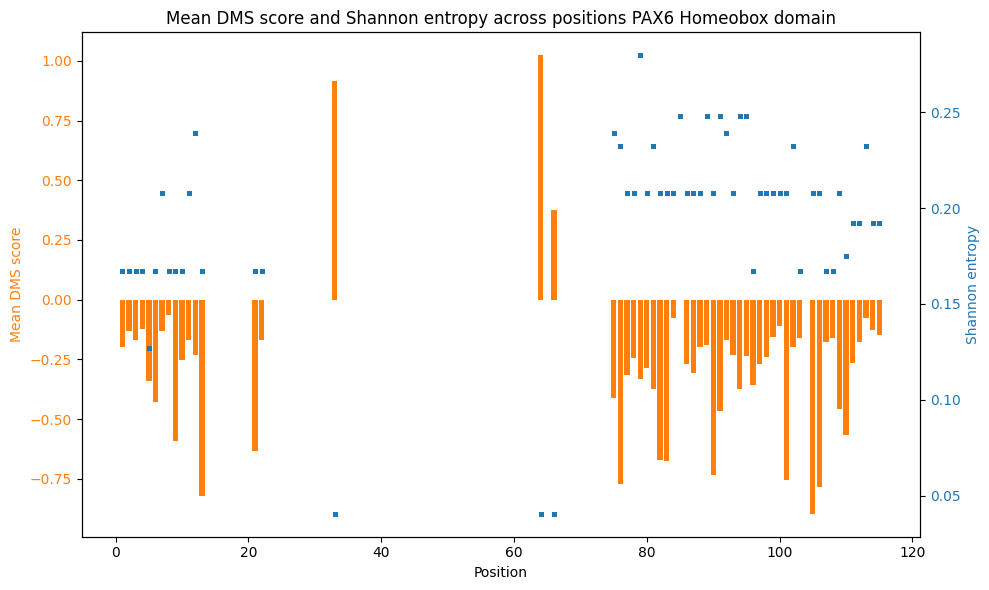

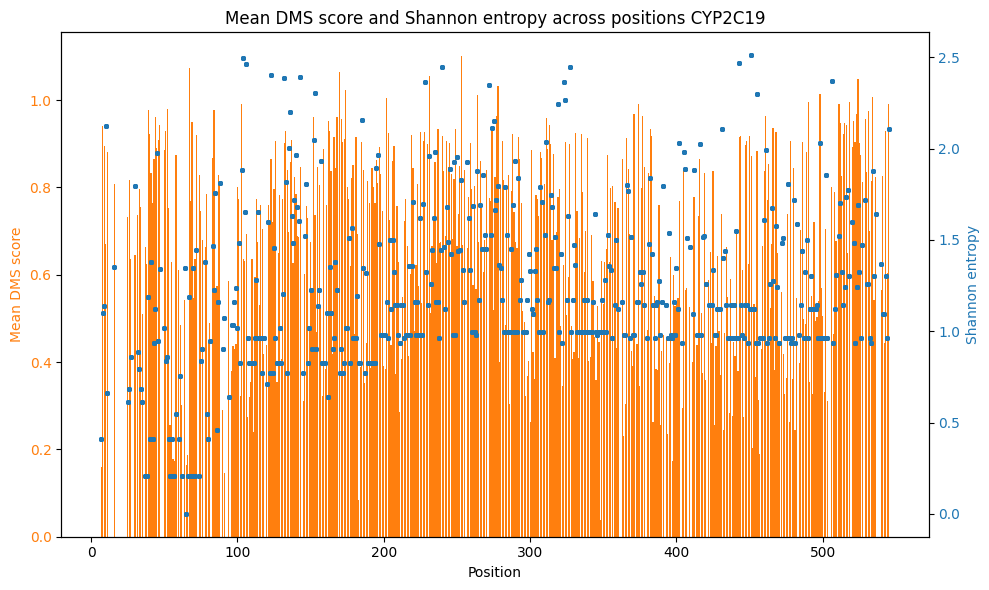

In [57]:
#PLOT mean DMS vs Shannon across positions - all positions are plotted
plot_dms_and_entropy('PAX6 Homeobox domain')
plot_dms_and_entropy('CYP2C19')

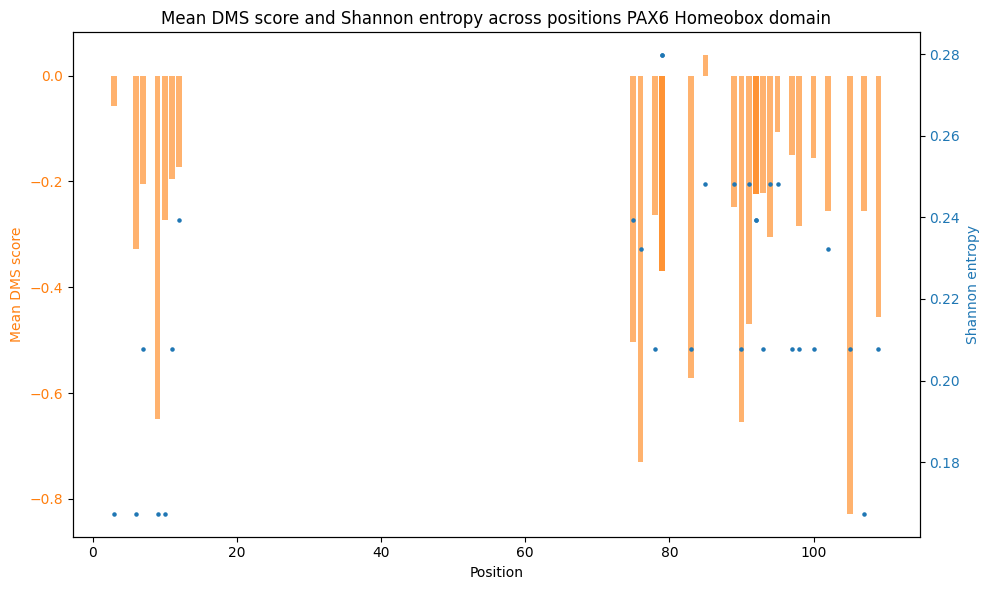

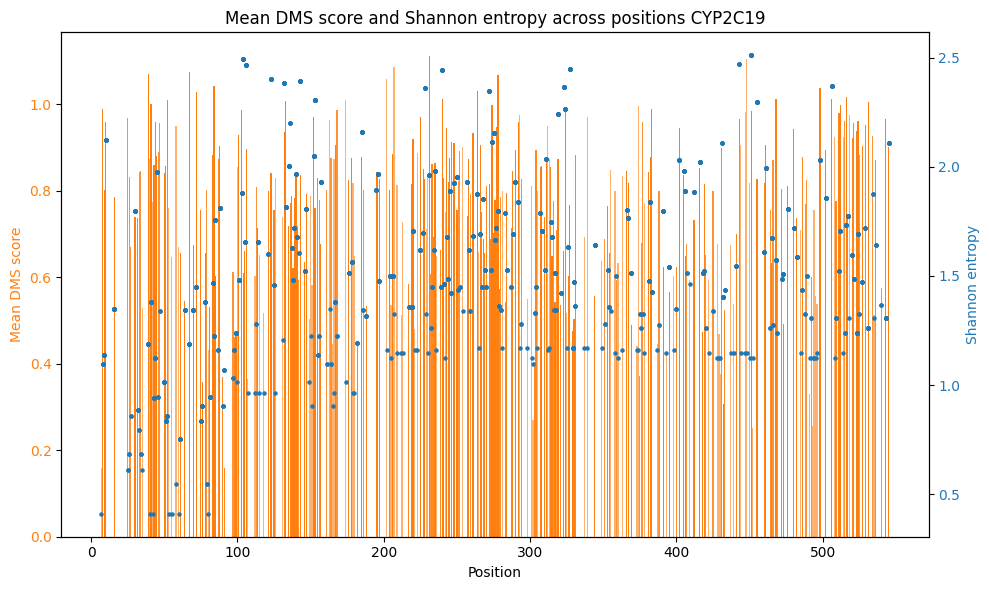

In [52]:
#PLOT mean DMS vs Shannon across positions - 
# - mutations with edit distance (number of nucleotides in codon ancestral aa is away from variant aa) >1 are filtered out from plot
# because it's evolutionary unlikely
plot_dms_and_entropy('PAX6 Homeobox domain')
plot_dms_and_entropy('CYP2C19')

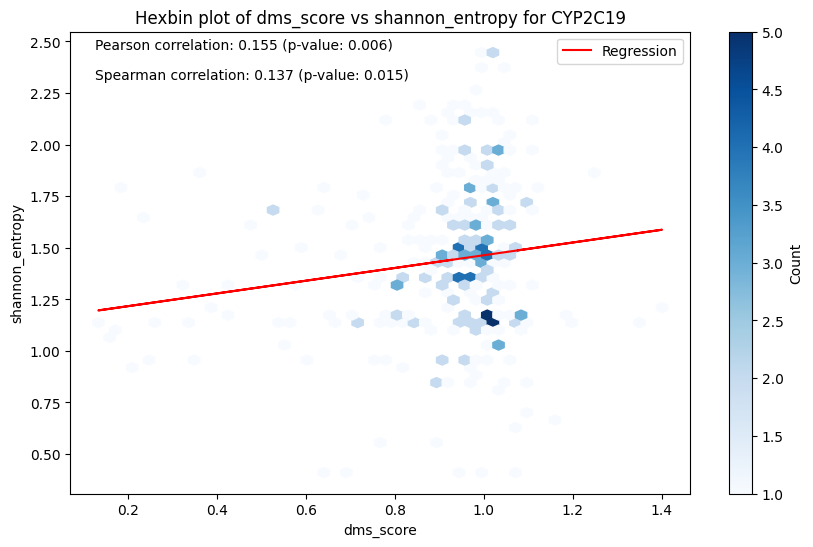

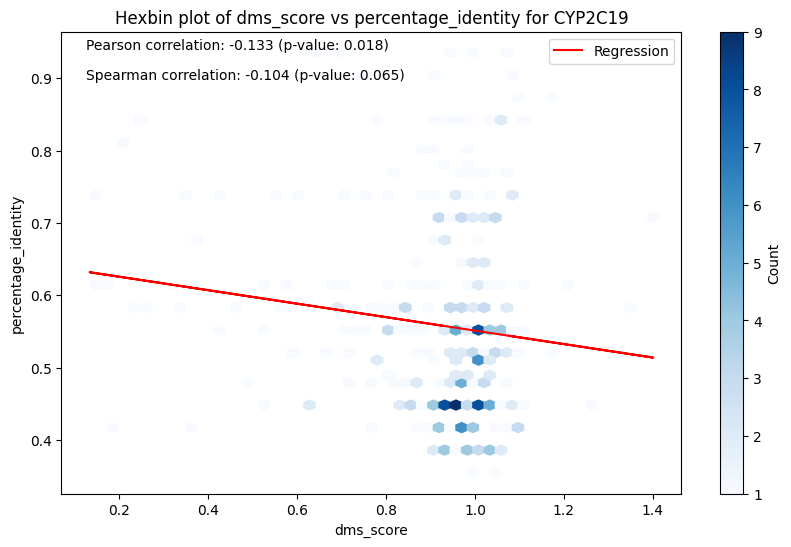

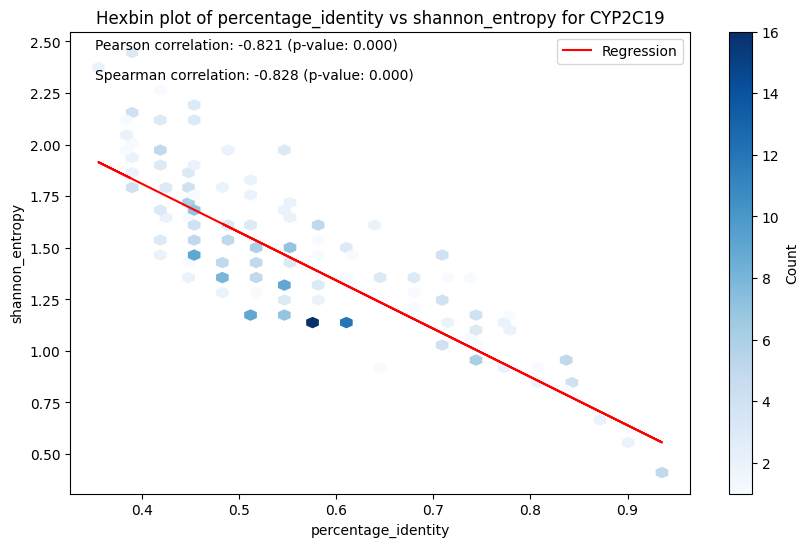

In [37]:
# PLOT correlations - 
# - mutations with edit distance (number of nucleotides in codon ancestral aa is away from variant aa) >1 are filtered out from plot
# because it's evolutionary unlikely
#visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'shannon_entropy', plot_type='scatter')
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'shannon_entropy', plot_type='hexbin')
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'percentage_identity', plot_type='hexbin')
visualize_correlations('CYP2C19', 'IntegratedData', 'percentage_identity', 'shannon_entropy', plot_type='hexbin')

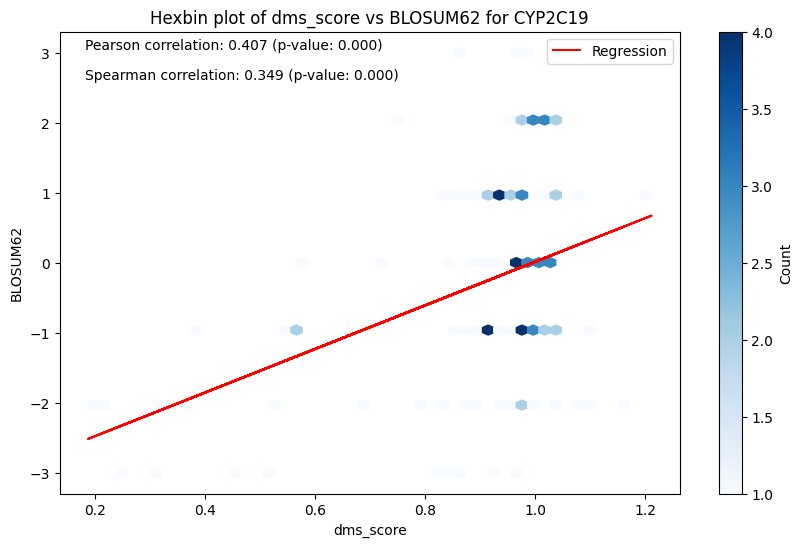

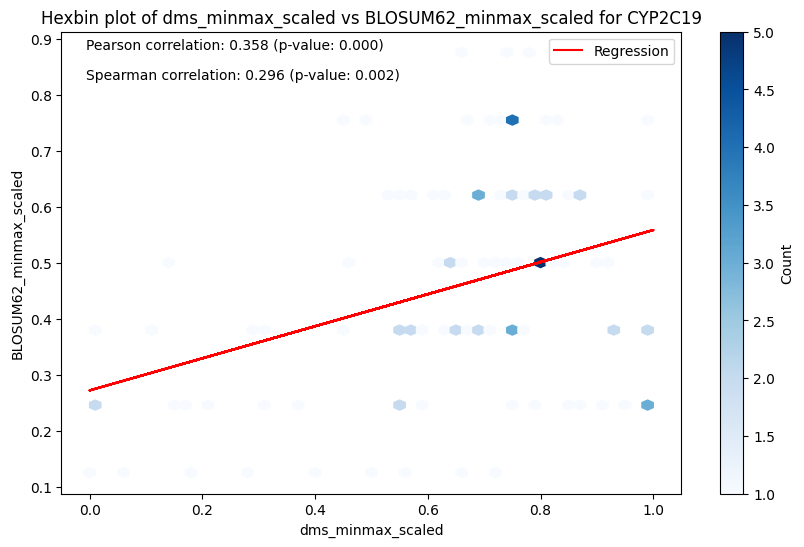

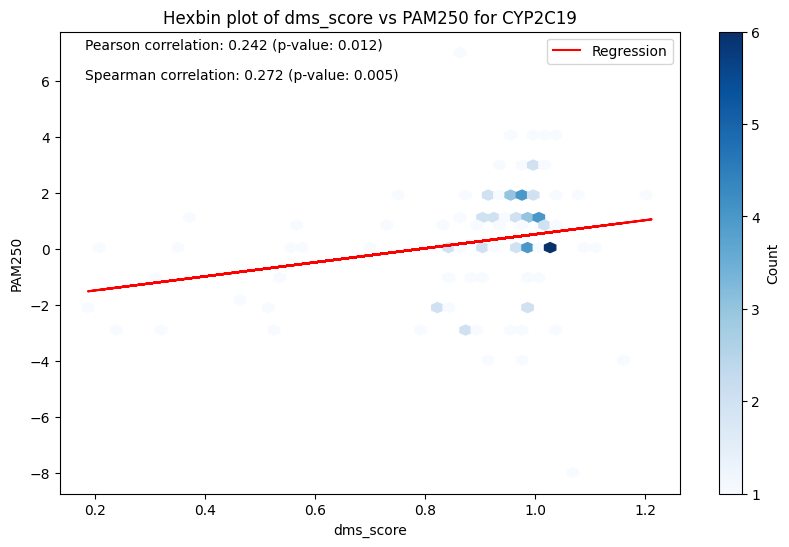

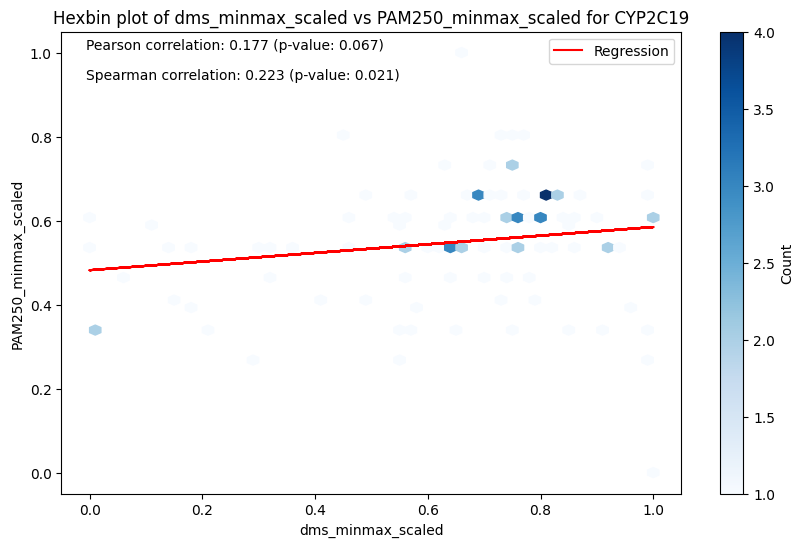

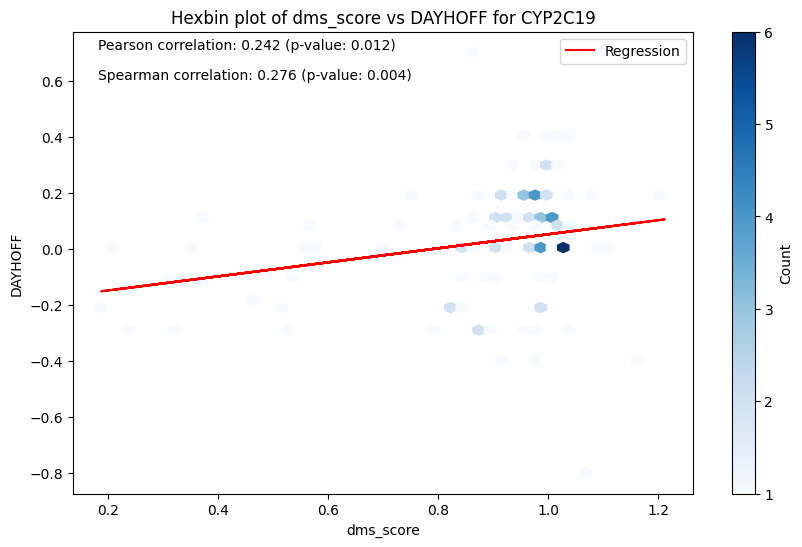

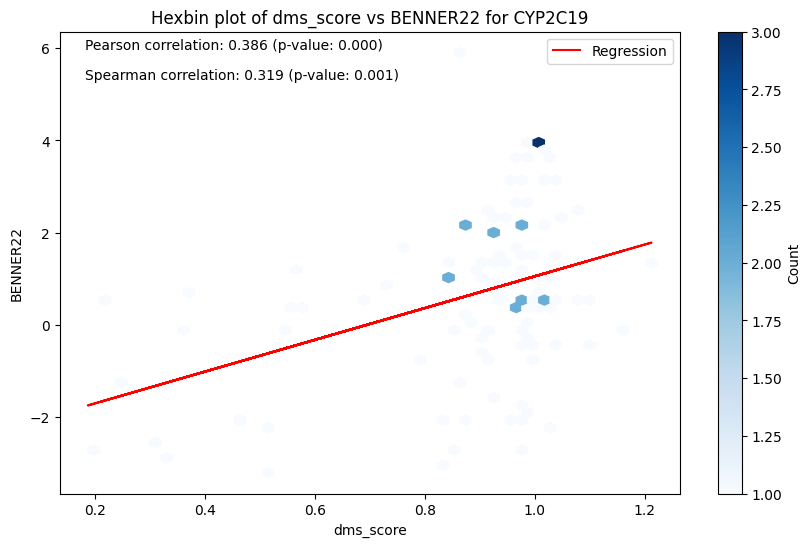

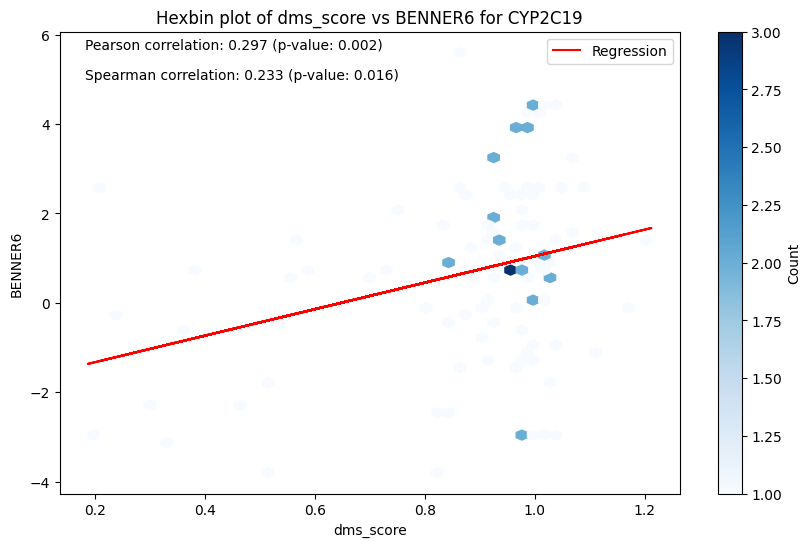

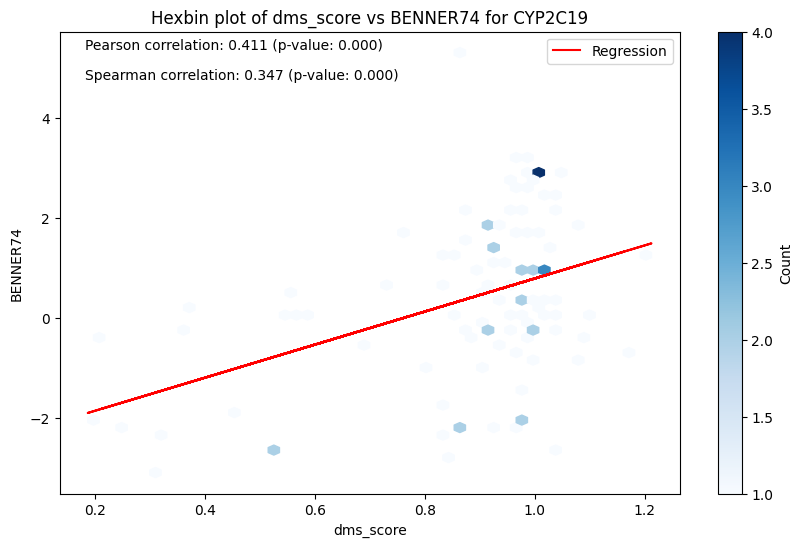

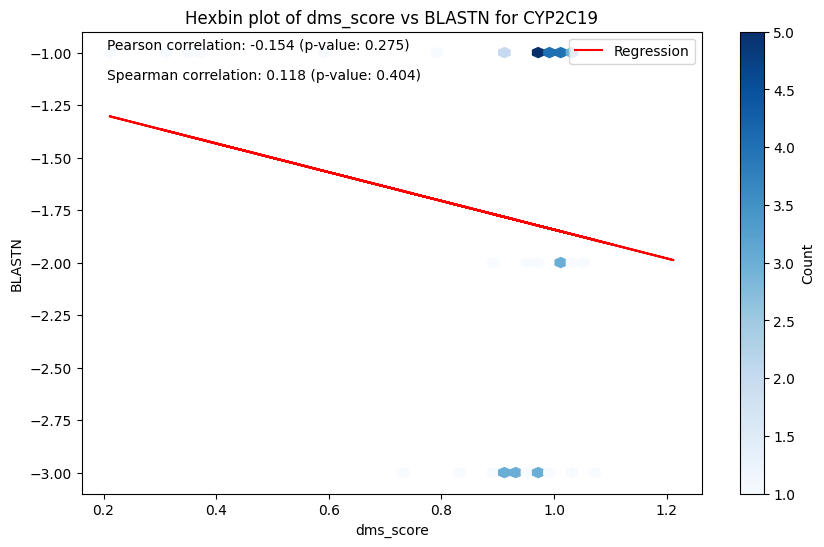

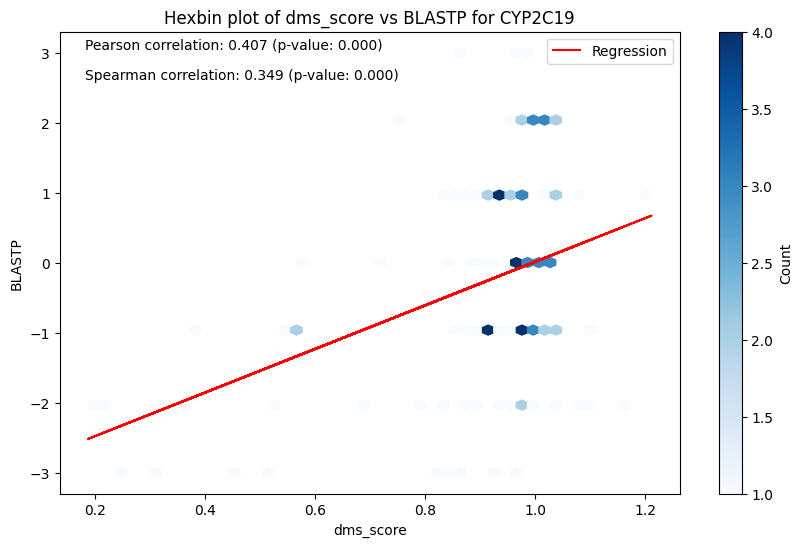

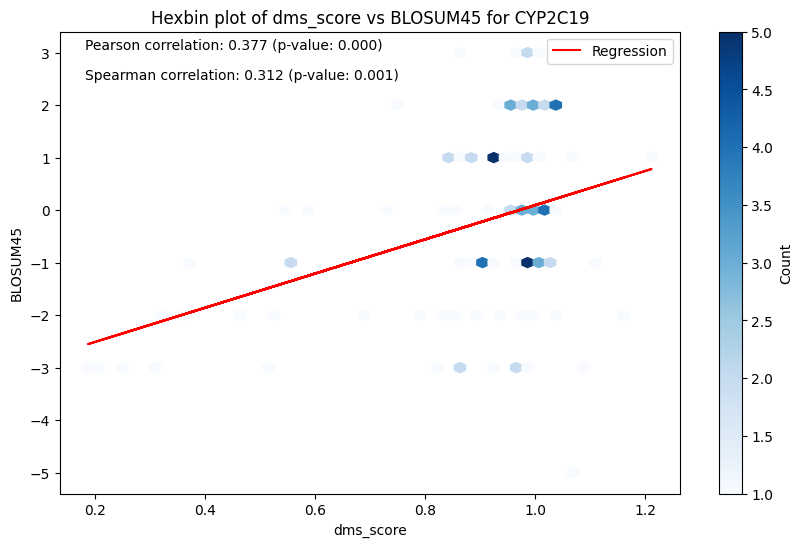

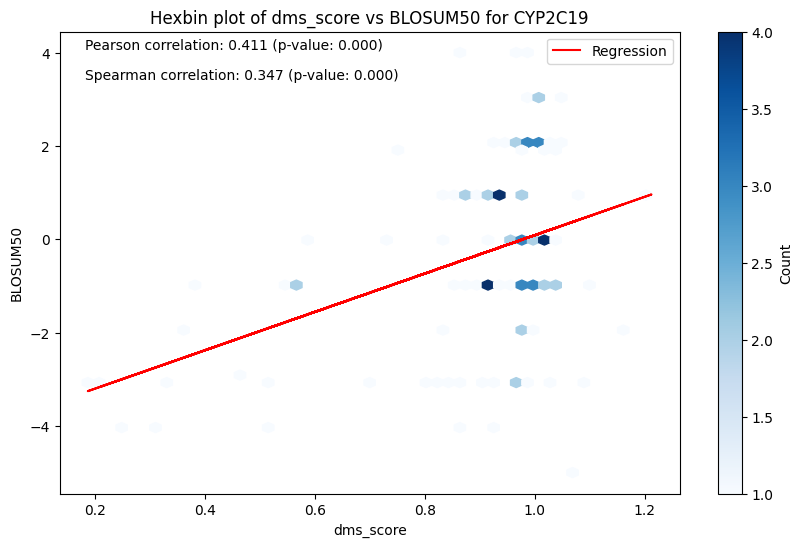

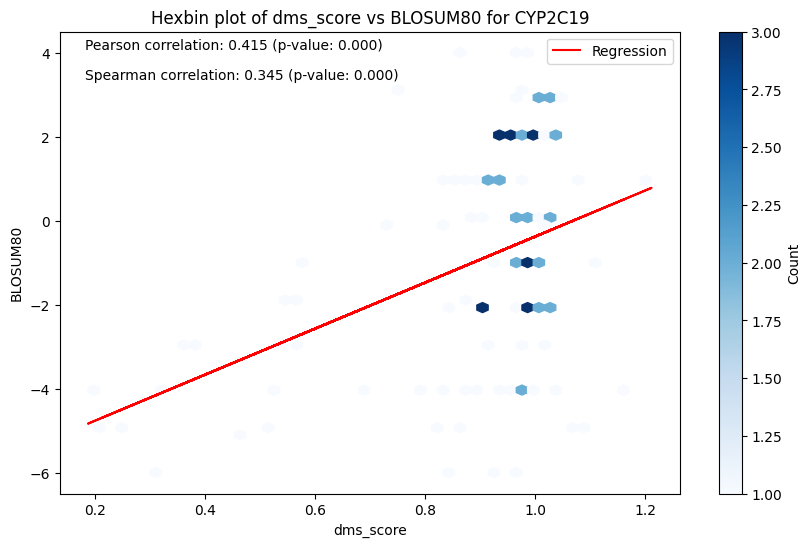

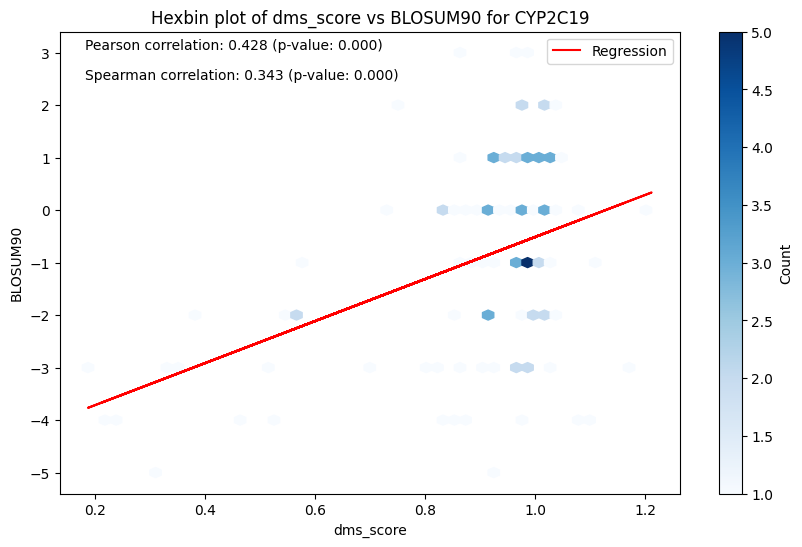

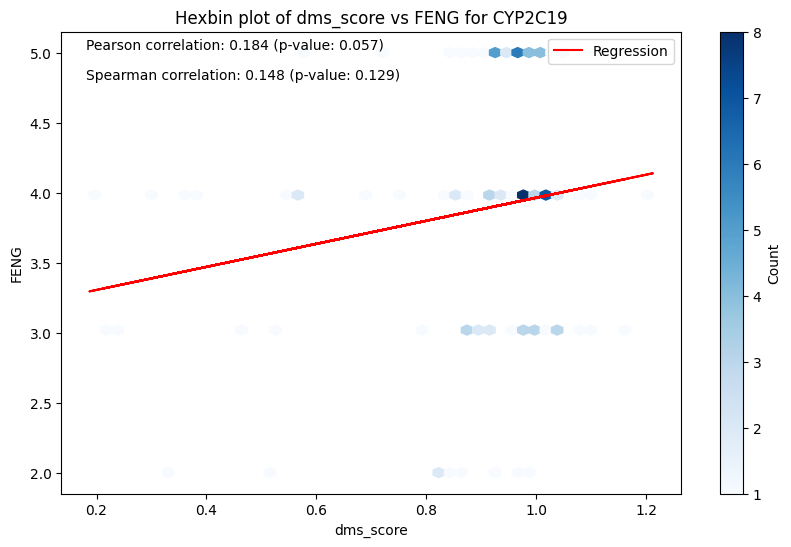

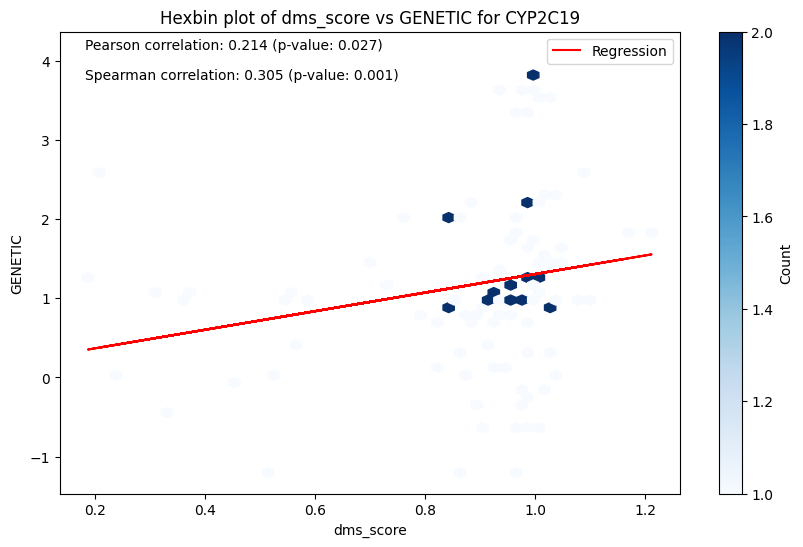

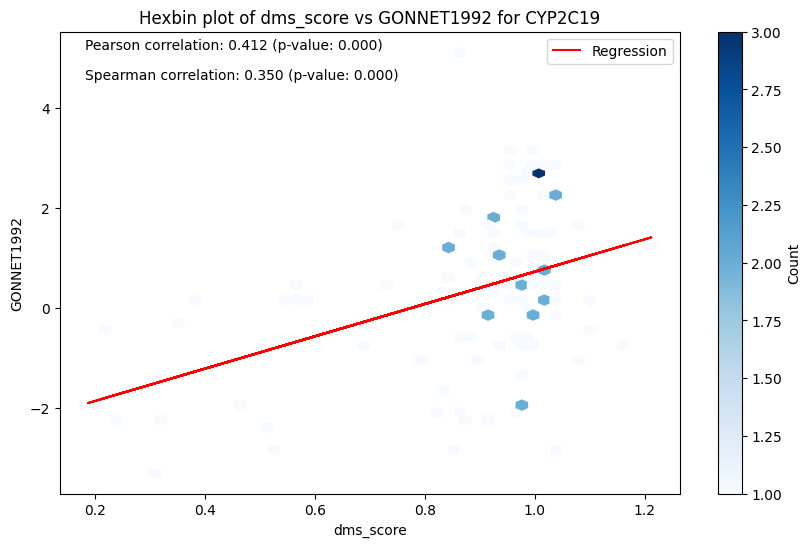

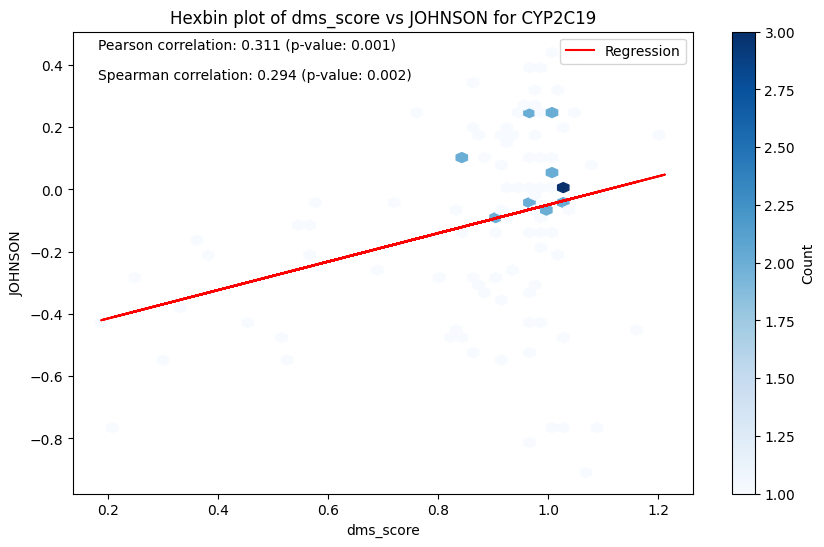

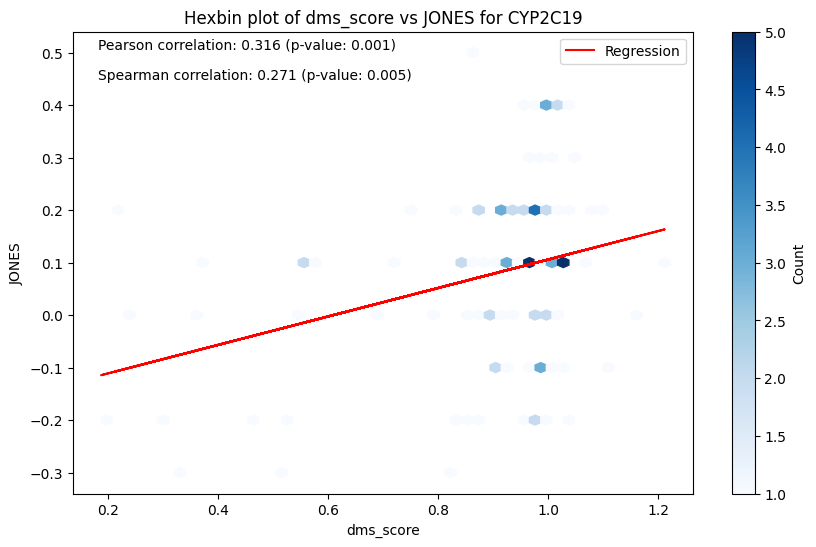

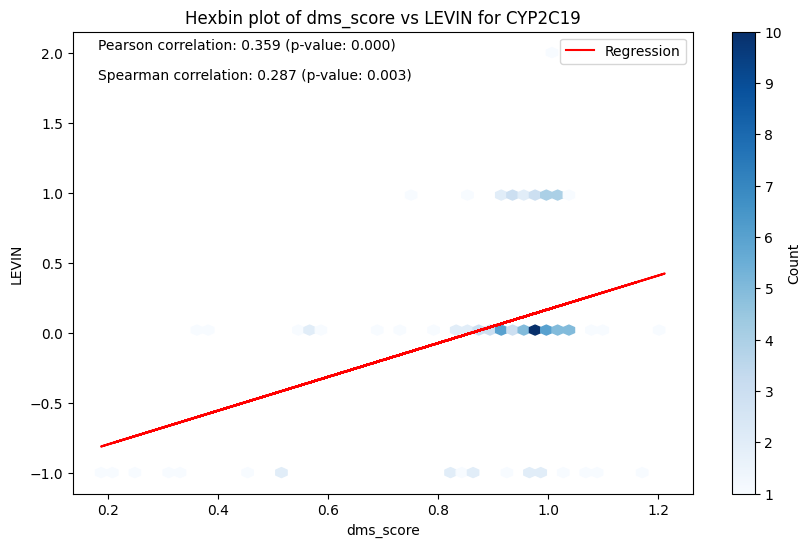

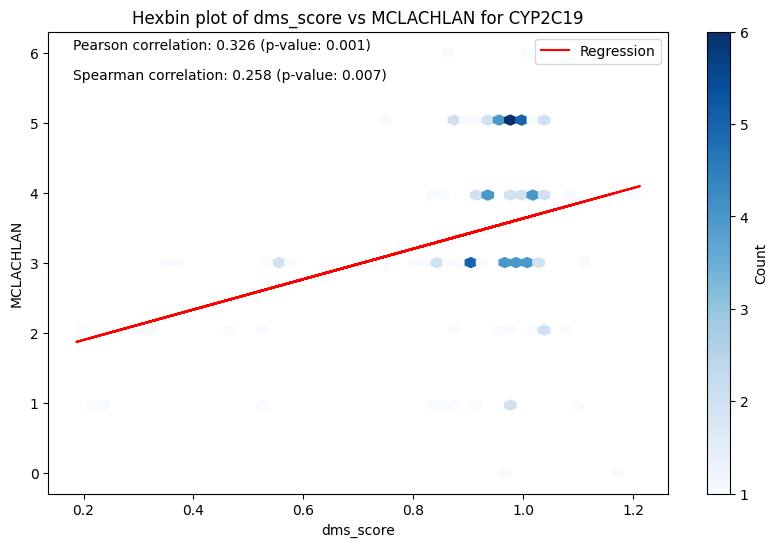

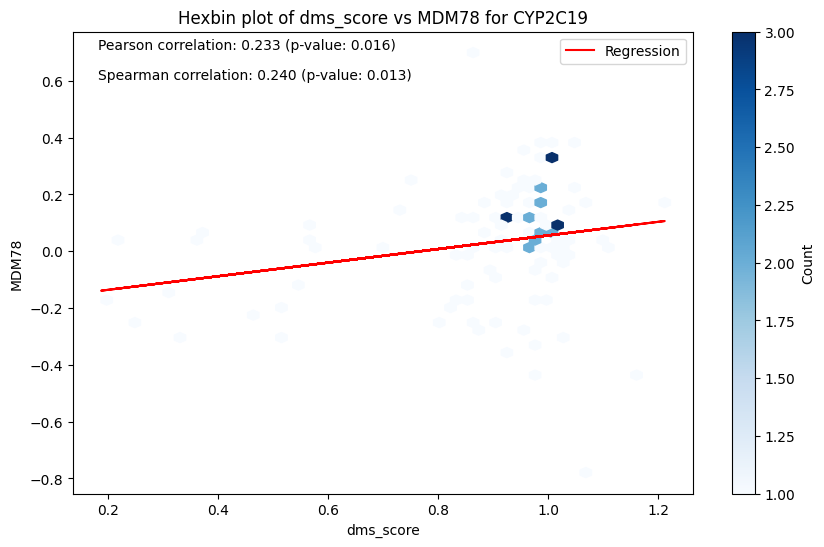

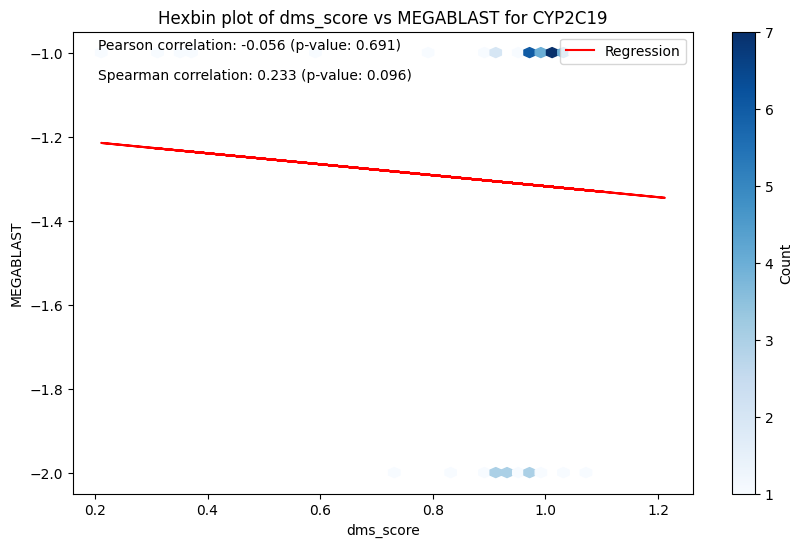

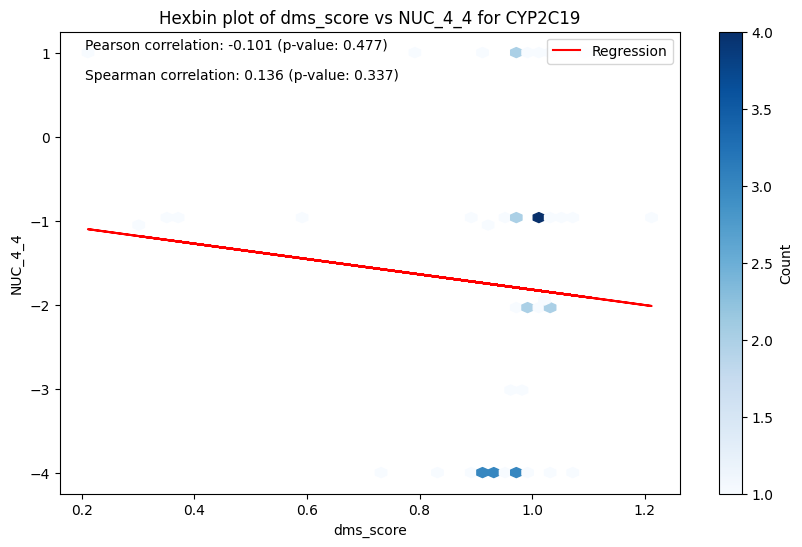

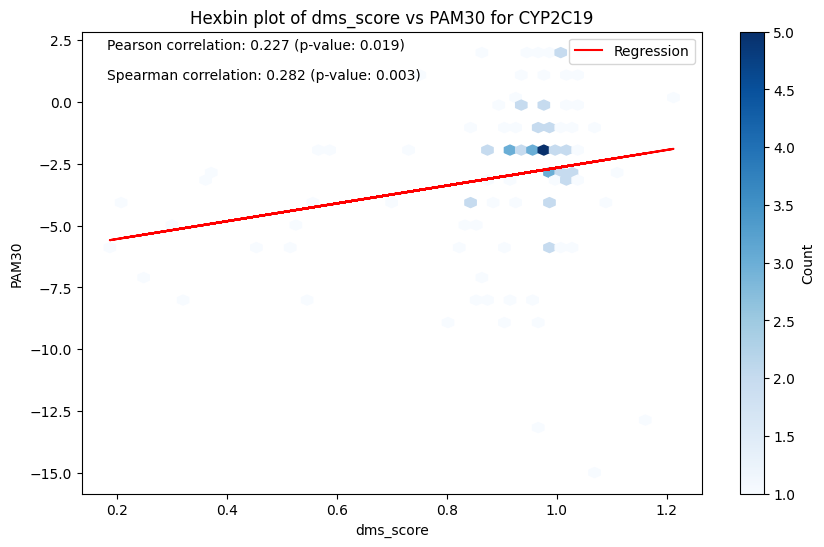

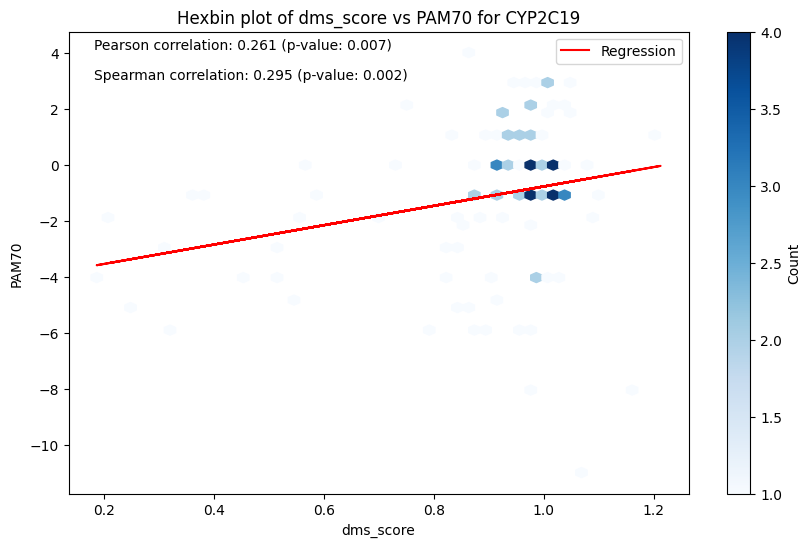

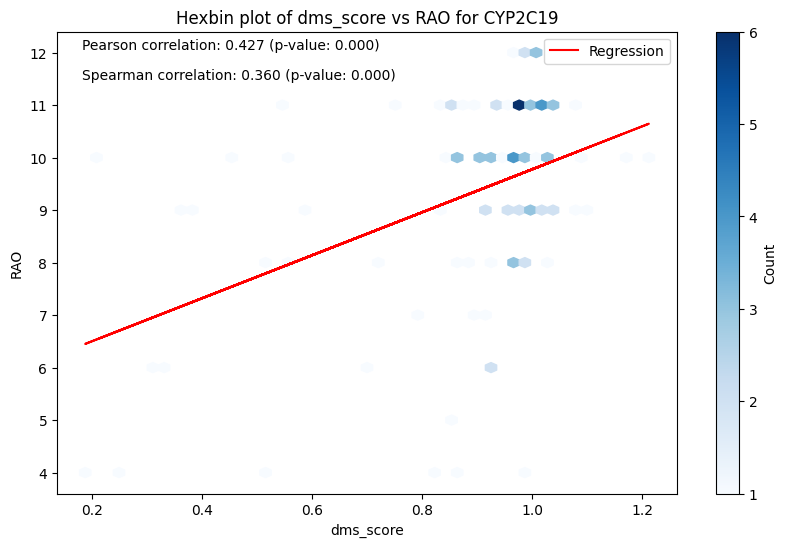

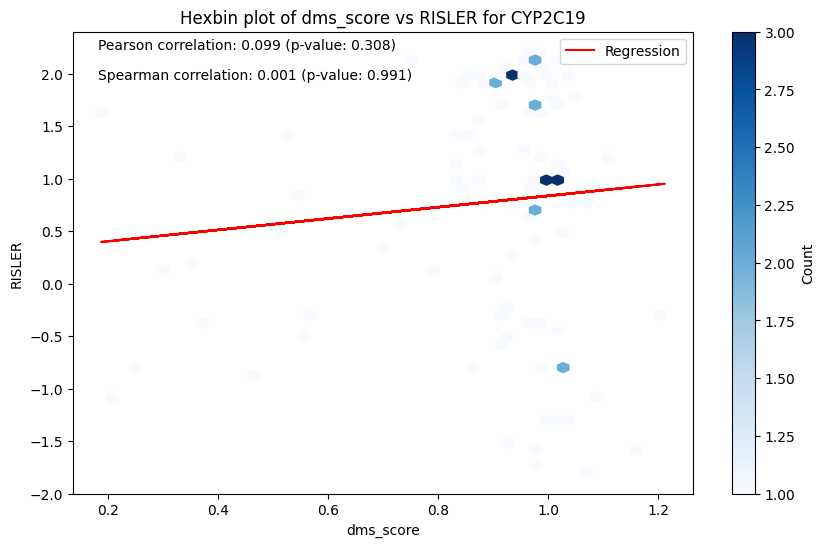

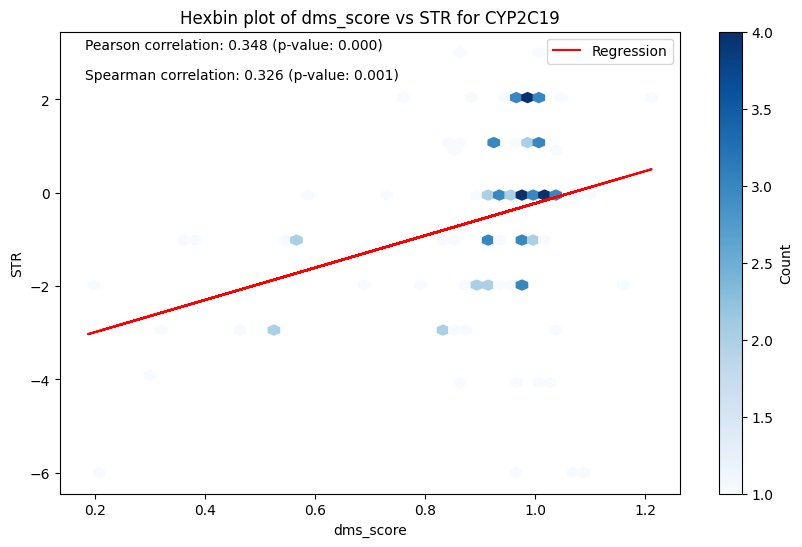

In [38]:
#visualize correlations dms scores vs substitution scores 
#(mean dms value is claculated for each unique pair of ancestral-variant residues)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'BLOSUM62', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_minmax_scaled', 'BLOSUM62_minmax_scaled', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'PAM250', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_minmax_scaled', 'PAM250_minmax_scaled', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'DAYHOFF', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'BENNER22', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'BENNER6', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'BENNER74', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'BLASTN', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'BLASTP', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'BLOSUM45', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'BLOSUM50', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'BLOSUM80', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'BLOSUM90', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'FENG', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'GENETIC', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'GONNET1992', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'JOHNSON', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'JONES', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'LEVIN', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'MCLACHLAN', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'MDM78', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'MEGABLAST', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'NUC_4_4', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'PAM30', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'PAM70', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'RAO', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'RISLER', plot_type='hexbin', mean_across_aa_pairs=True)
visualize_correlations('CYP2C19', 'IntegratedData', 'dms_score', 'STR', plot_type='hexbin', mean_across_aa_pairs=True)

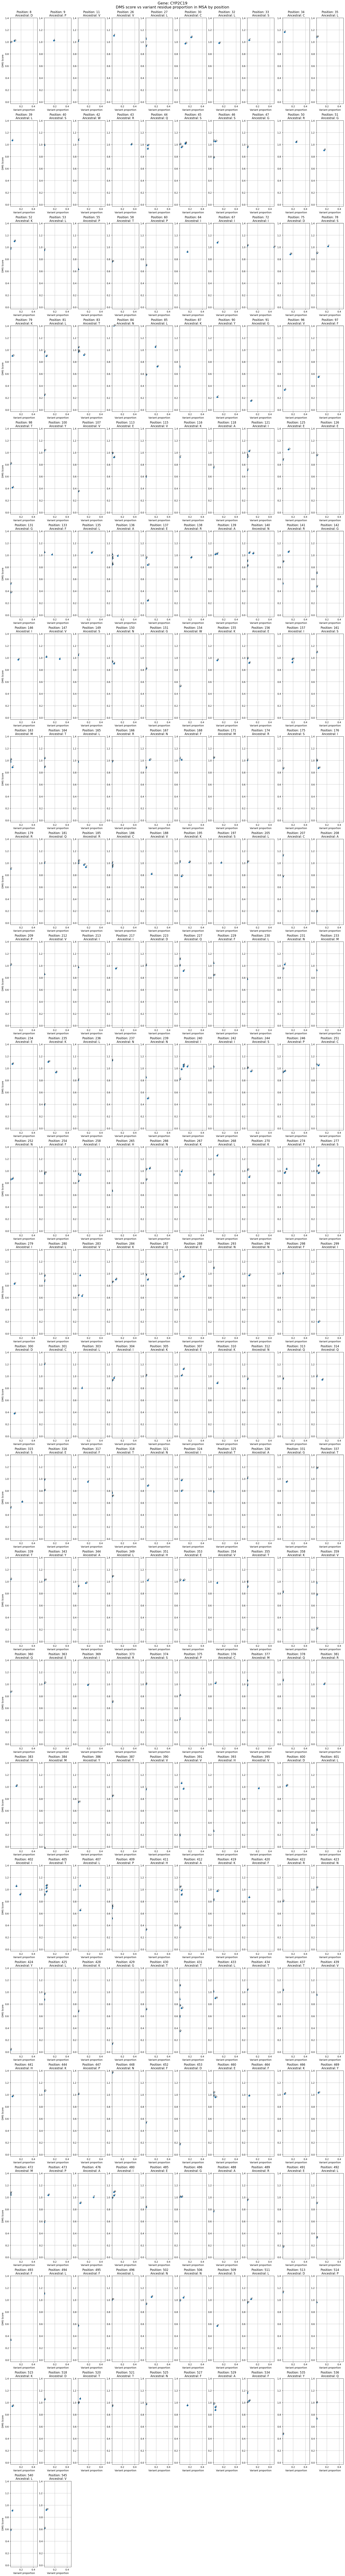

In [59]:
plot_var_residue_percent_vs_dms_grid('CYP2C19')

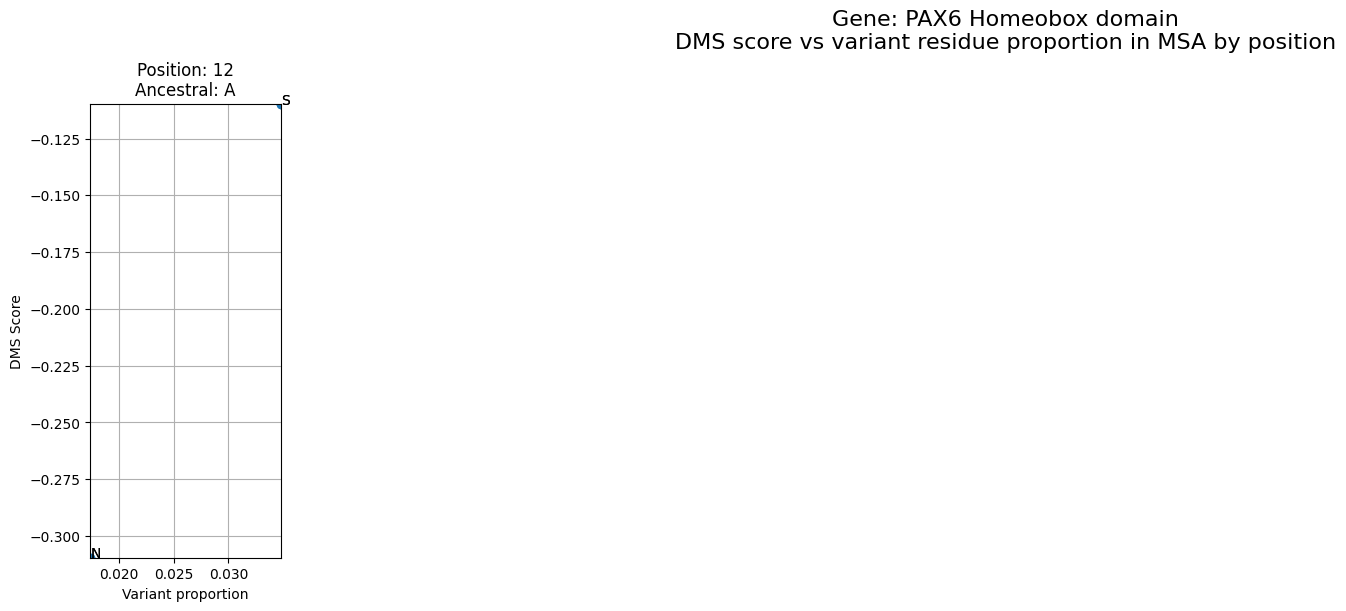

In [60]:
plot_var_residue_percent_vs_dms_grid('PAX6 Homeobox domain')

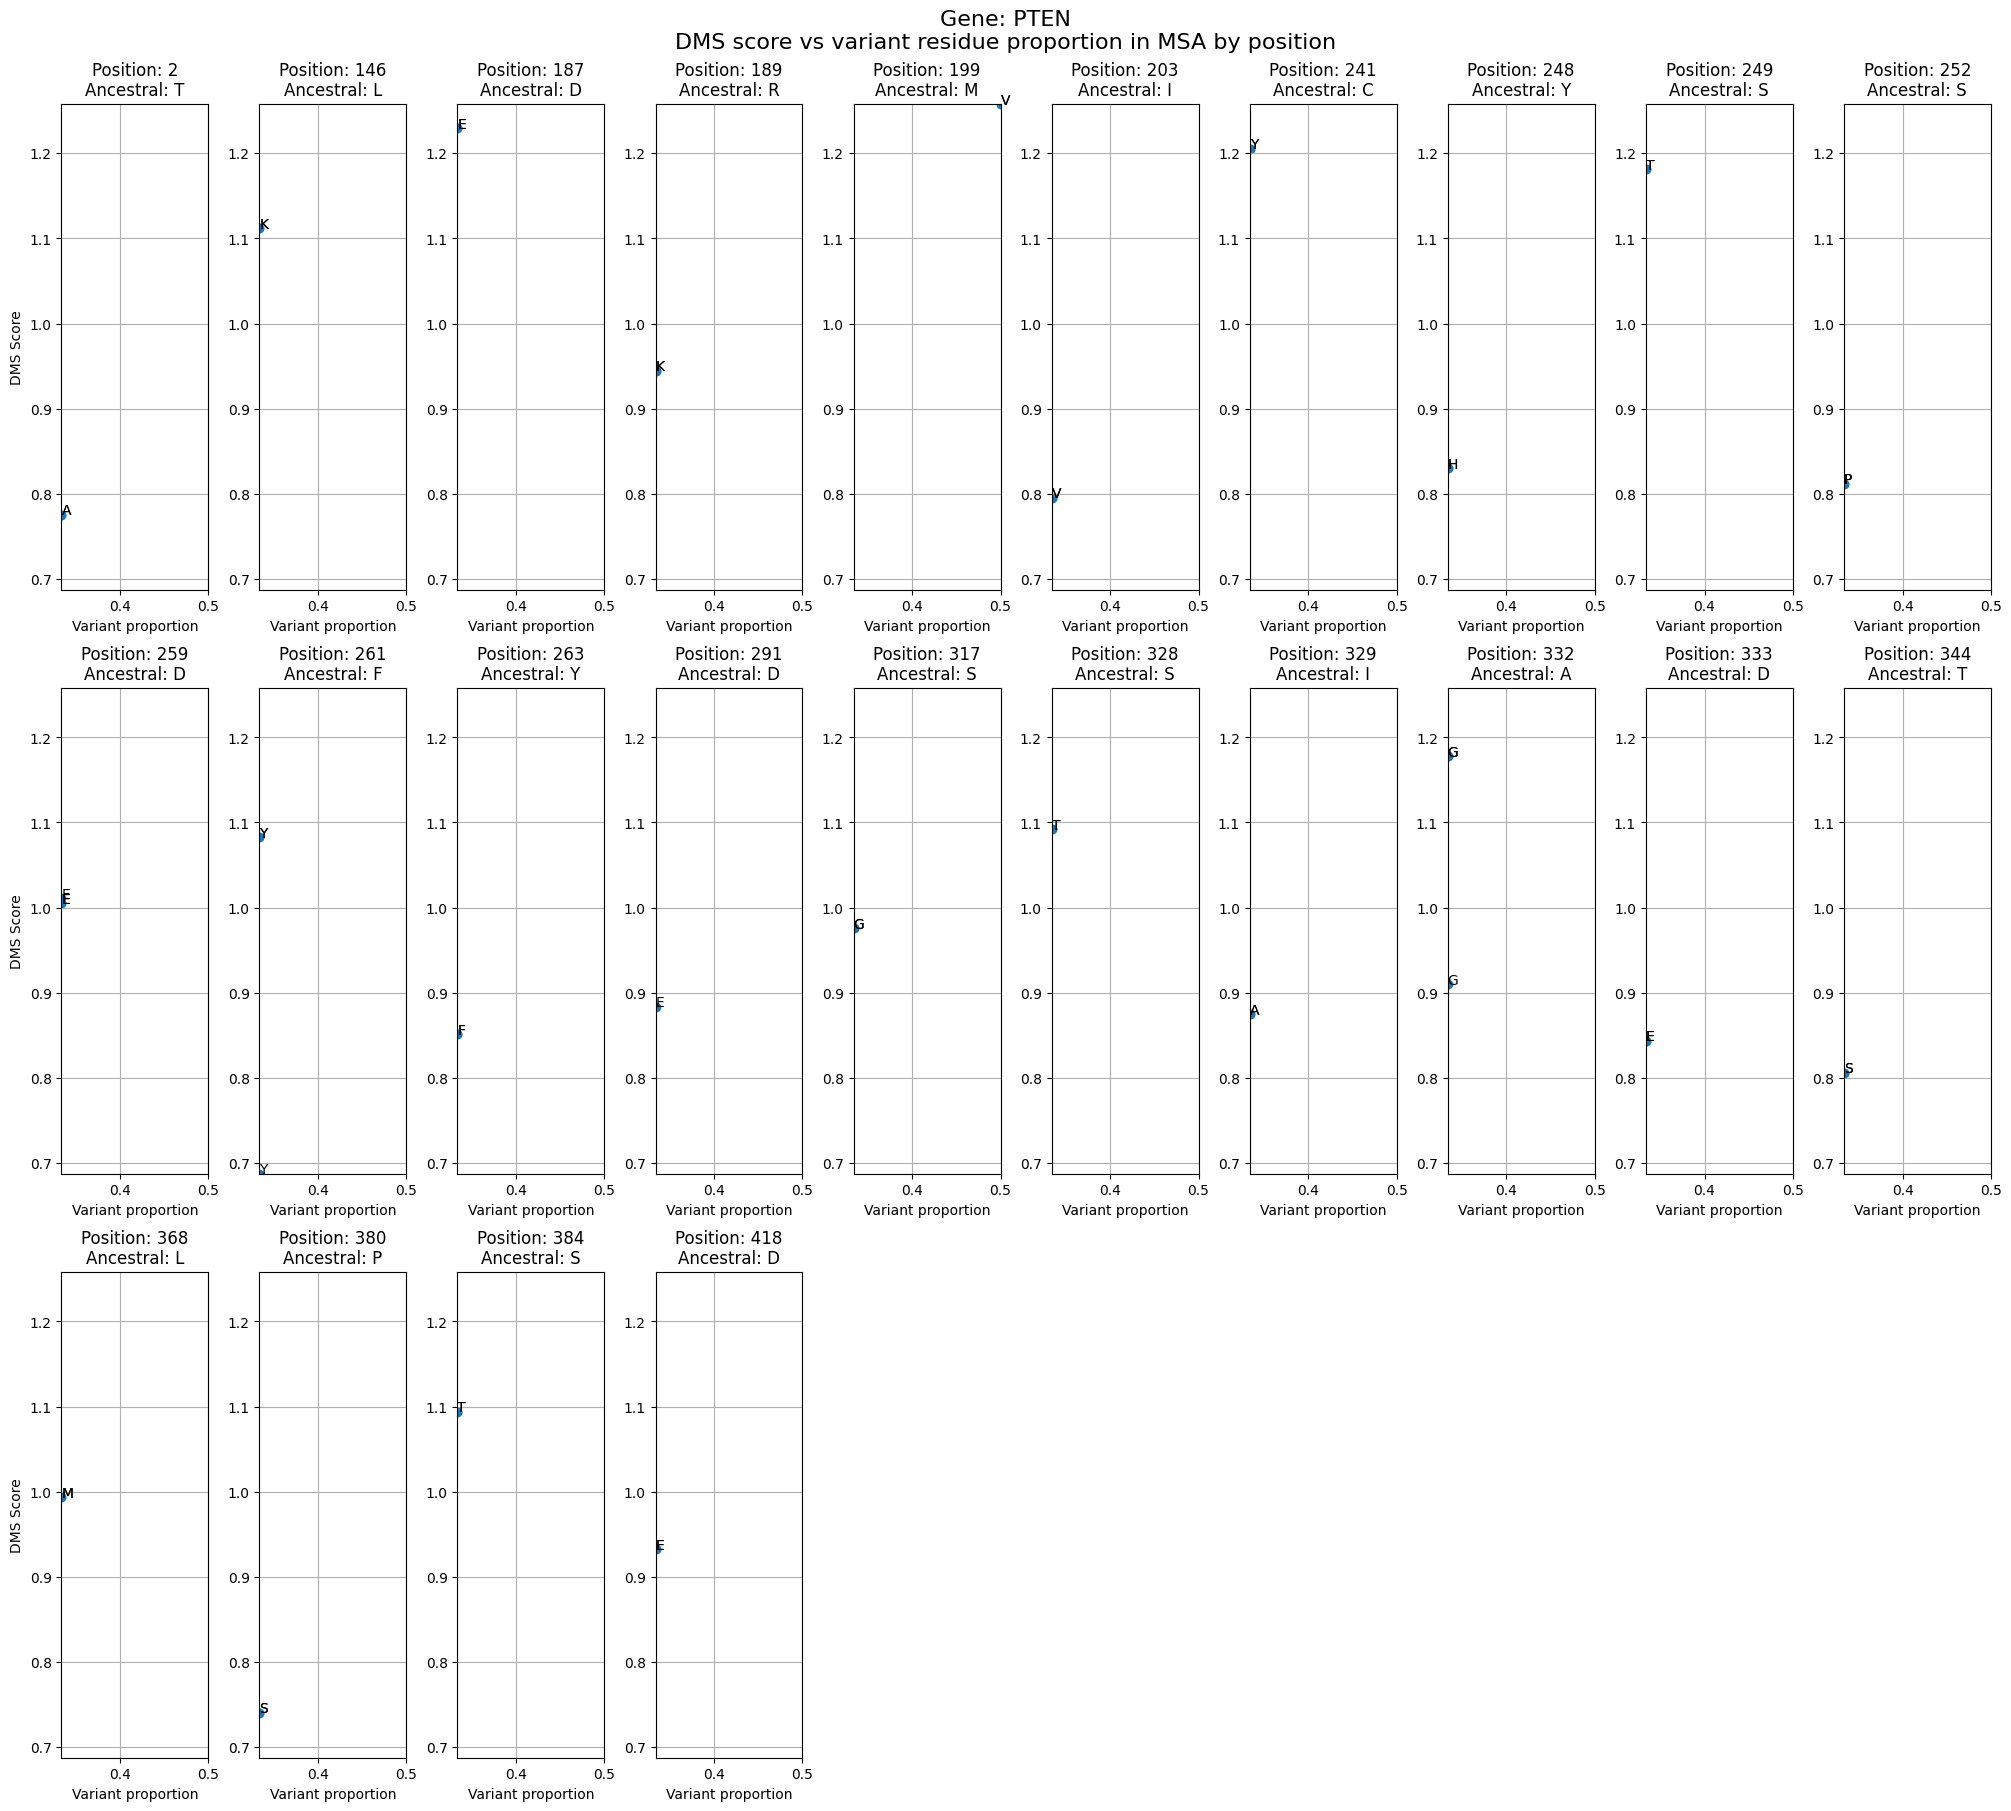

In [61]:
plot_var_residue_percent_vs_dms_grid('PTEN')

In [ ]:
plot_var_residue_percent_vs_dms_individual('CYP2C19')

In [ ]:
plot_var_residue_percent_vs_dms_individual('PAX6 Homeobox domain')

In [ ]:
plot_var_residue_percent_vs_dms_individual('PTEN')

In [ ]:
plot_pair_distribution('CYP2C19')

In [ ]:
plot_pair_distribution('PTEN')

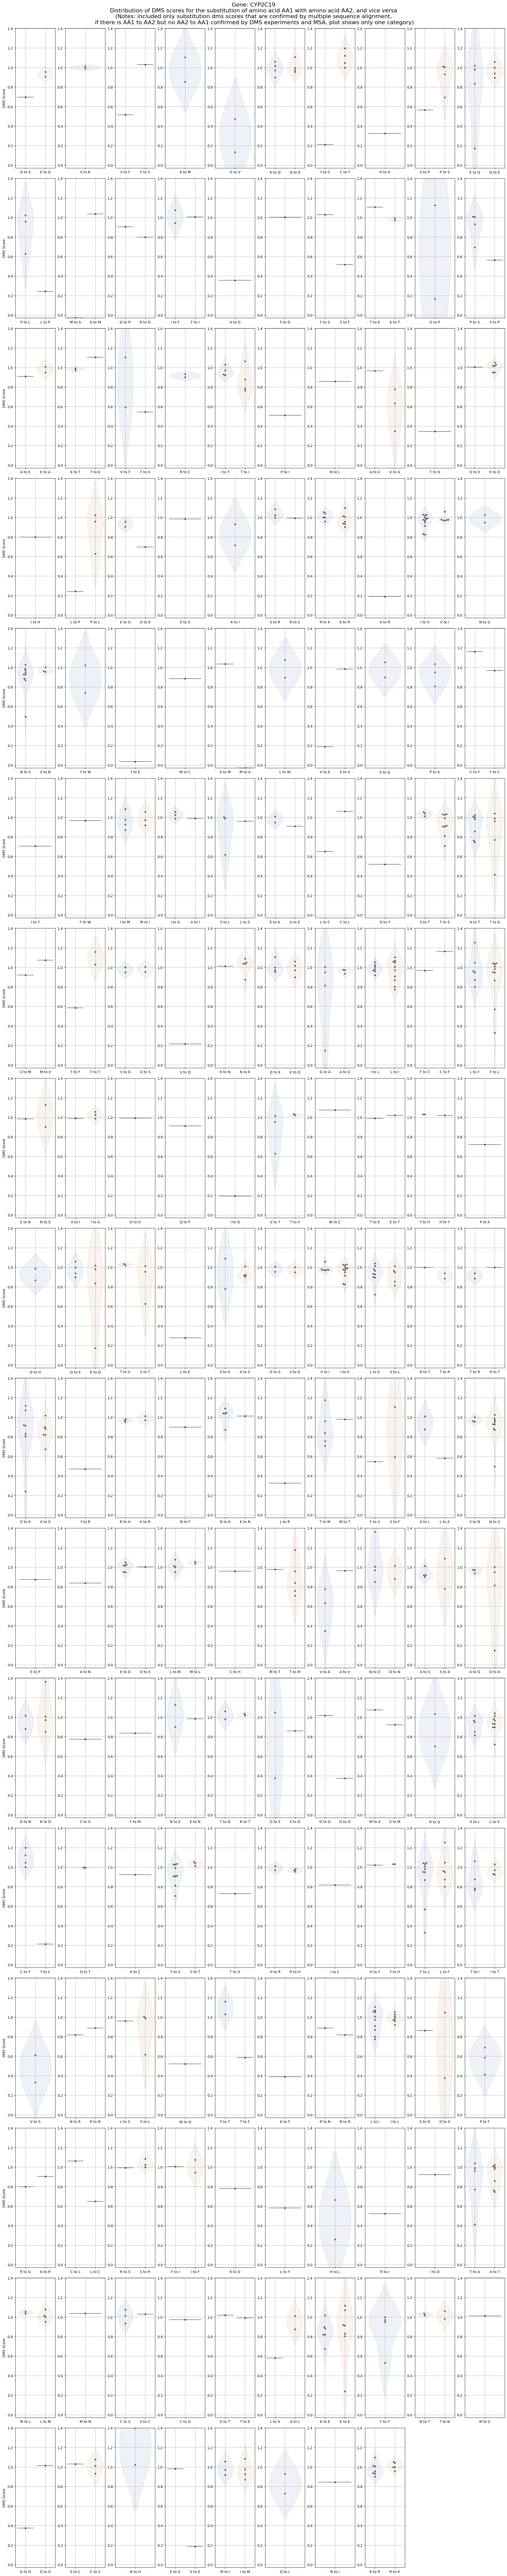

In [45]:
plot_pair_distribution_grid('CYP2C19')

Data sample (first 5 rows): [(2, 'T', 'A', 0.3333333333333333, 0.15429113433689773), (146, 'L', 'K', 0.3333333333333333, 0.743976502206567), (187, 'D', 'E', 0.3333333333333333, 0.9508624681648147), (189, 'R', 'K', 0.3333333333333333, 0.4506932683328091), (199, 'M', 'V', 0.5, 1.0)]
IndexError: tuple index out of range
IndexError: tuple index out of range
IndexError: tuple index out of range
IndexError: tuple index out of range
IndexError: tuple index out of range
IndexError: tuple index out of range
IndexError: tuple index out of range
IndexError: tuple index out of range
IndexError: tuple index out of range
IndexError: tuple index out of range
IndexError: tuple index out of range
IndexError: tuple index out of range
IndexError: tuple index out of range
IndexError: tuple index out of range
IndexError: tuple index out of range


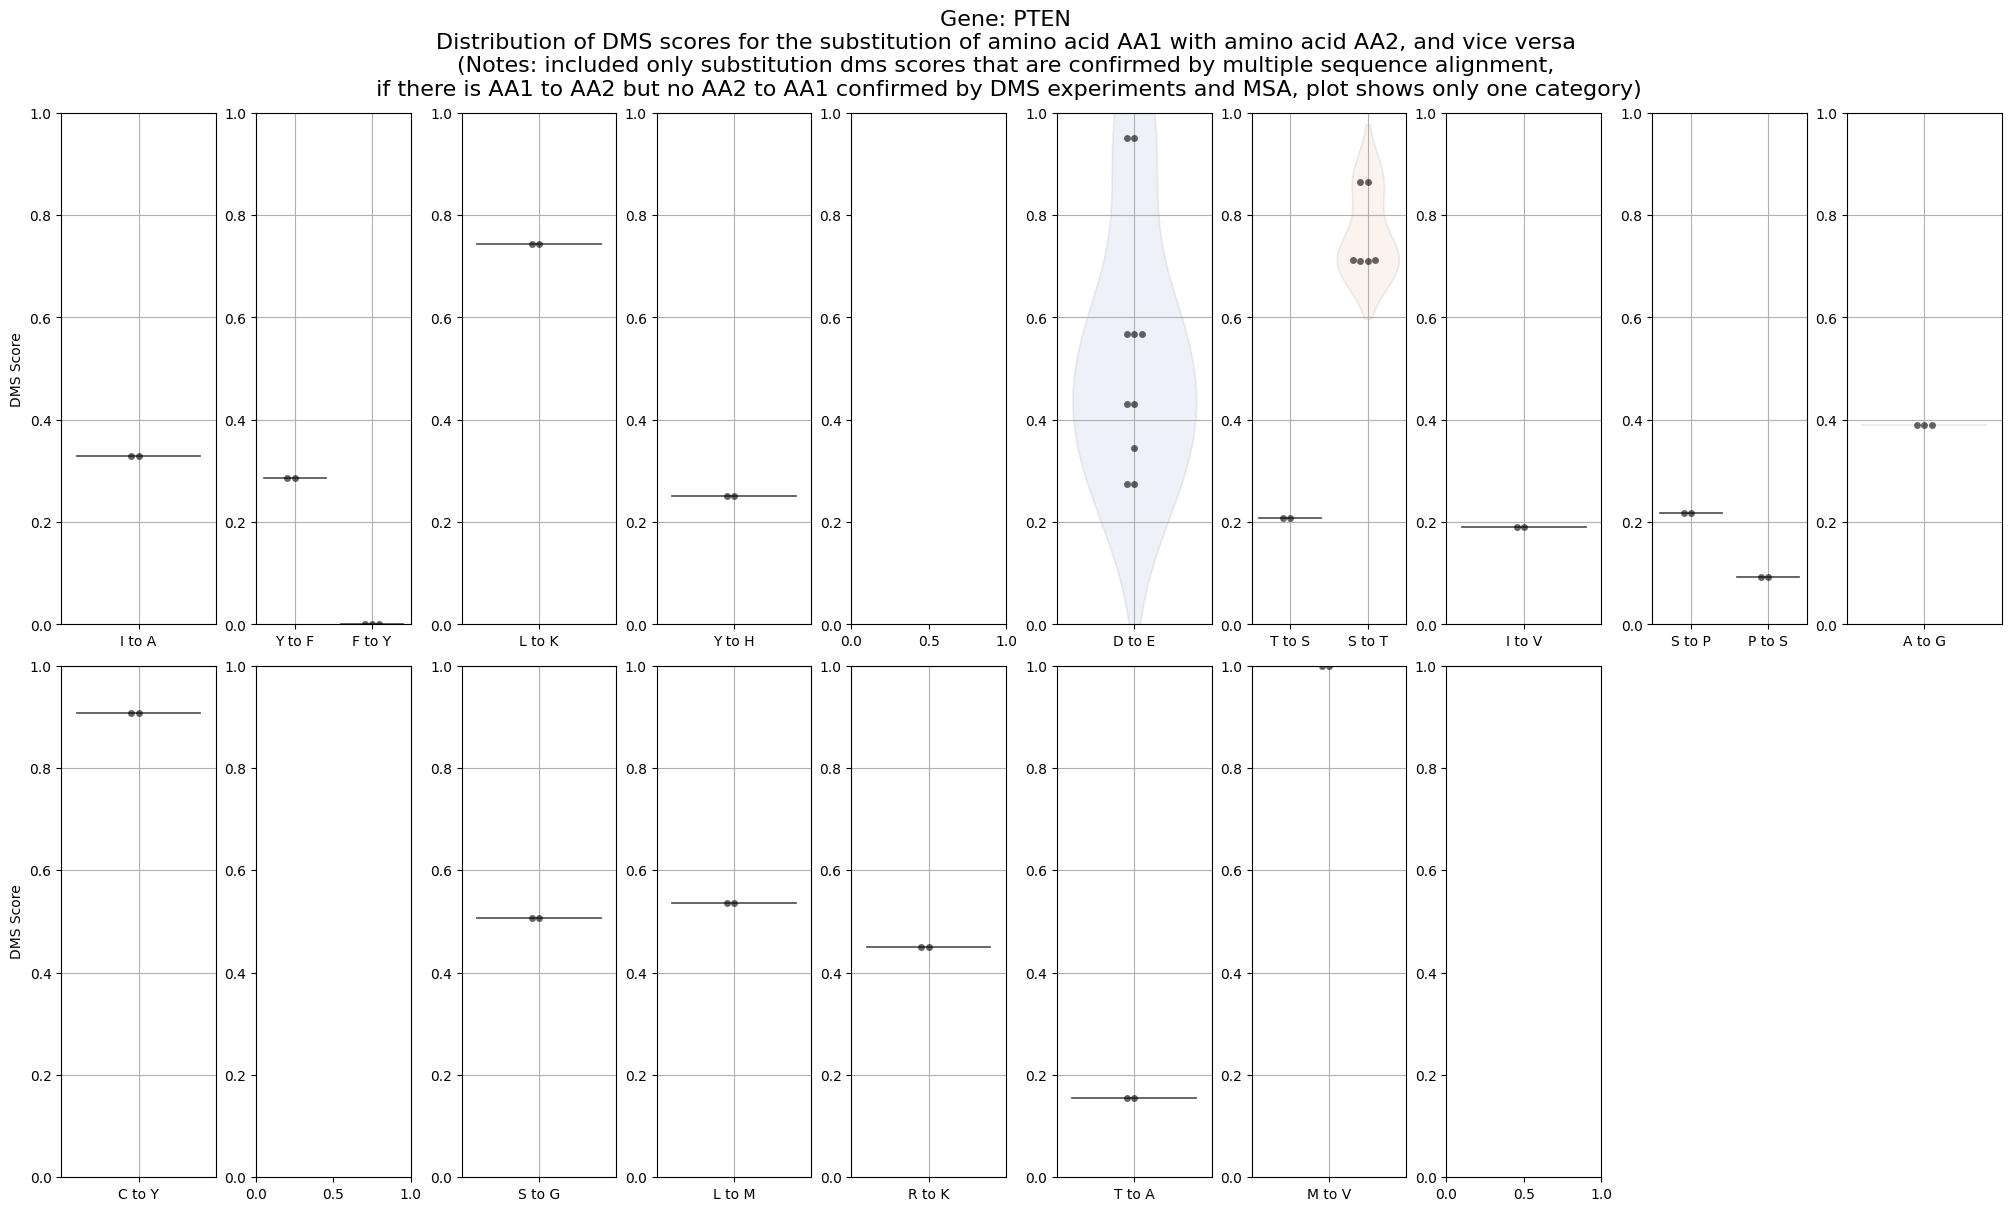

In [71]:
plot_pair_distribution_grid_with_blosum('PTEN', scaled=True)

Data sample (first 5 rows): [(2, 'T', 'A', 0.3333333333333333, 0.7755377977), (146, 'L', 'K', 0.3333333333333333, 1.111883757), (187, 'D', 'E', 0.3333333333333333, 1.229887802), (189, 'R', 'K', 0.3333333333333333, 0.9446002597), (199, 'M', 'V', 0.5, 1.257914969)]


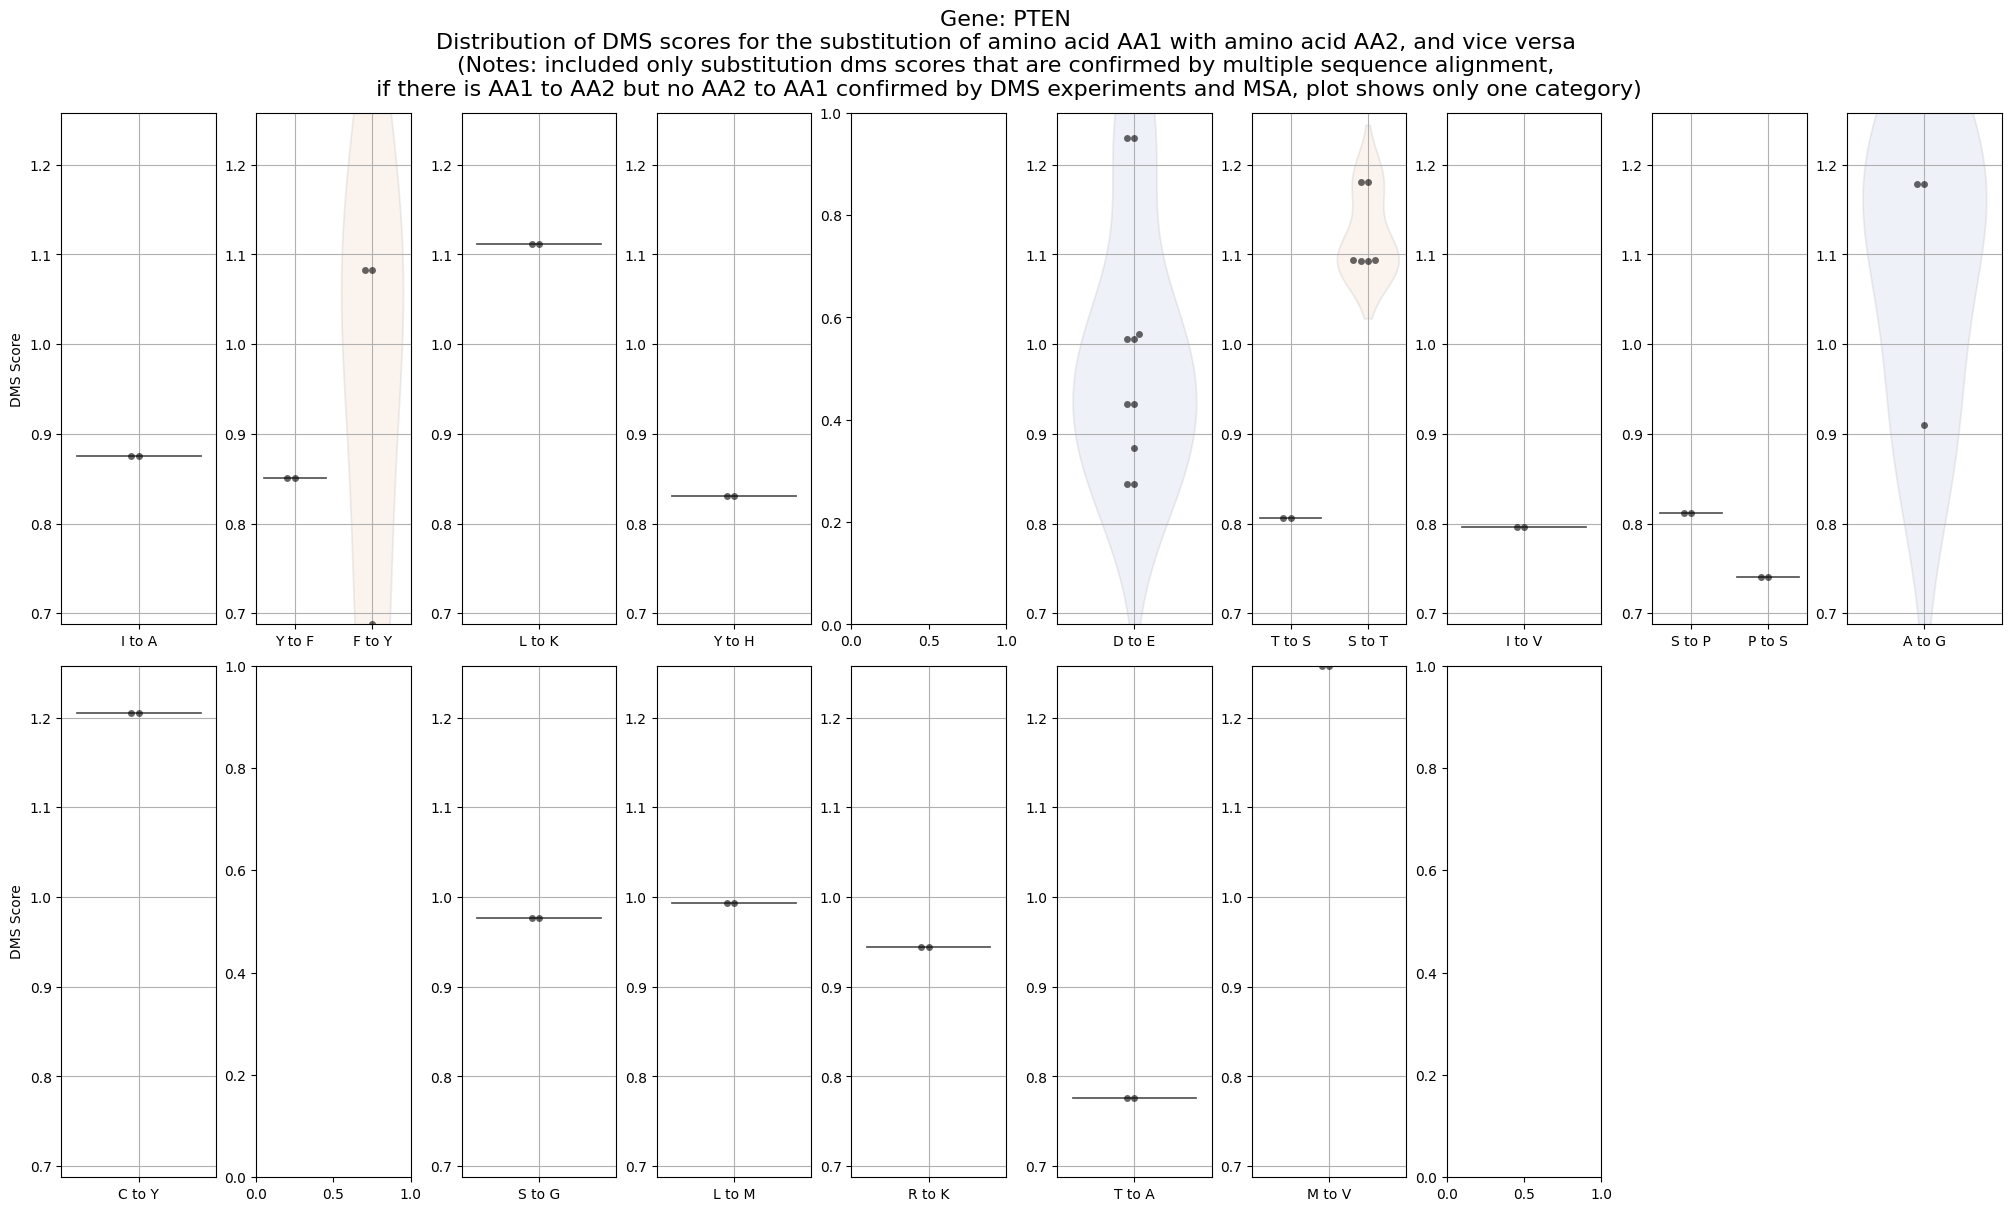

In [72]:
plot_pair_distribution_grid_with_blosum('PTEN')

In [ ]:
# temporary
# CLEAN table
table_name = 'DMS'
clean_table(table_name)

#CLEAN MSA for specific gene
cursor.execute(f'''
        DELETE FROM MSA
        WHERE mutation_id IN (
            SELECT Mutation.mutation_id
            FROM Mutation
            JOIN Species ON Mutation.species_id = Species.species_id
            JOIN Gene ON Mutation.gene_id = Gene.gene_id
            WHERE Gene.gene_id = 2
        );
    ''')
conn.commit()

In [ ]:
# Close the connection
conn.close()